In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'appliances-energy-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2536%2F4231%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240902%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240902T093829Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09b3d72c70e505a9298472ca9040f073b860dfdee01118684e632d90589c848f196646b0027bd9c26a5b9ed0b99e16cc73e4816c4366e3aaab66ed604e4d4e71c27aa68458aca8ac3258fd78f1097e7cee9c97de1245d9c7276294d9cc308ac0c9f2e8ce6b6ef5faeda3bf38cd6d4ae6dc6b8195bd6422ac9dbc0b1d558a46e1171bce3be88ccec0d934d53e2779a8961370ed550de84e5c905879063909994d514ce30c15eea4c69e04a45b45ccee63195caabba2953a2381975ead0bd9a47649332476629af976ee522f6198e600b68192795214ed3bd7762d05a8d237bea44eb75490edb97cf98c6696f86b38db8bef492b6621921506e9d129b42f52c41c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1794477 bytes downloaded
Downloaded and uncompressed: appliances-energy-prediction
Data source import complete.


In [2]:
import pandas as pd
#importing the data set
data_raw = pd.read_csv('/kaggle/input/appliances-energy-prediction/KAG_energydata_complete.csv')


Data Collection

The above code can be used to directly download the data from Kaggle else it can be stored in local directory and accessed using below code

In [ ]:
# Access the file from local directory
from google.colab import files
uploaded = files.upload()
data_raw = pd.read_csv('energydata_complete.csv')

Saving energydata_complete.csv to energydata_complete.csv


In [3]:
! pip install scikeras

In [4]:
# Libraries required for this project
import pandas as pd
import numpy as np
# Required for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px

#Required for Preprocessing and Validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# Neural Network/RNN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GRU
from scikeras.wrappers import KerasRegressor



In [5]:

#creating a copy of data set
data = data_raw.copy()

# check if the data sest is a dataframe
print(isinstance(data, pd.DataFrame))

True


In [6]:
# Dataset Rows & Columns count
num_rows, num_cols = data.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 19735
Number of columns: 29


Exploratory Data Analysis

In [7]:
# Datatype Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [8]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [9]:
data.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [6]:
# Rename original column names to new column names
column_mapping = {'T1': 'KITCHEN_TEMP',
    'RH_1': 'KITCHEN_HUM',
    'T2': 'LIVING_TEMP',
    'RH_2' :'LIVING_HUM',
    'T3': 'BEDROOM_TEMP',
    'RH_3':'BEDROOM_HUM',
    'T4' : 'OFFICE_TEMP',
    'RH_4' : 'OFFICE_HUM',
    'T5' : 'BATHROOM_TEMP',
    'RH_5': 'BATHROOM_HUM',
    'T6':'OUTSIDE_TEMP_build',
    'RH_6': 'OUTSIDE_HUM_build',
    'T7': 'IRONING_ROOM_TEMP',
    'RH_7' : 'IRONING_ROOM_HUM',
    'T8' :'TEEN_ROOM_TEMP',
    'RH_8' : 'TEEN_ROOM_HUM',
    'T9': 'PARENTS_ROOM_TEMP',
    'RH_9': 'PARENTS_ROOM_HUM',
    'T_out' :'OUTSIDE_TEMP_wstn',
    'RH_out' :'OUTSIDE_HUM_wstn'}

data.rename(columns=column_mapping, inplace=True)

In [7]:
# Convert 'date' to datetime and extract new features from it

data['date'] = pd.to_datetime(data['date'])#,format = '%Y-%m-%d %H:%M')

# Extract date components and create new columns
data['month'] = data['date'].dt.month
data['hour'] = data['date'].dt.hour
data['dayofweek'] = data['date'].dt.dayofweek
data['minutes'] = data['date'].dt.minute

data.head()

,date,Appliances,lights,KITCHEN_TEMP,KITCHEN_HUM,LIVING_TEMP,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_TEMP,...,OUTSIDE_HUM_wstn,Windspeed,Visibility,Tdewpoint,rv1,rv2,month,hour,dayofweek,minutes
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,1,17,0,0
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,1,17,0,10
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,1,17,0,20
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,1,17,0,30
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,1,17,0,40


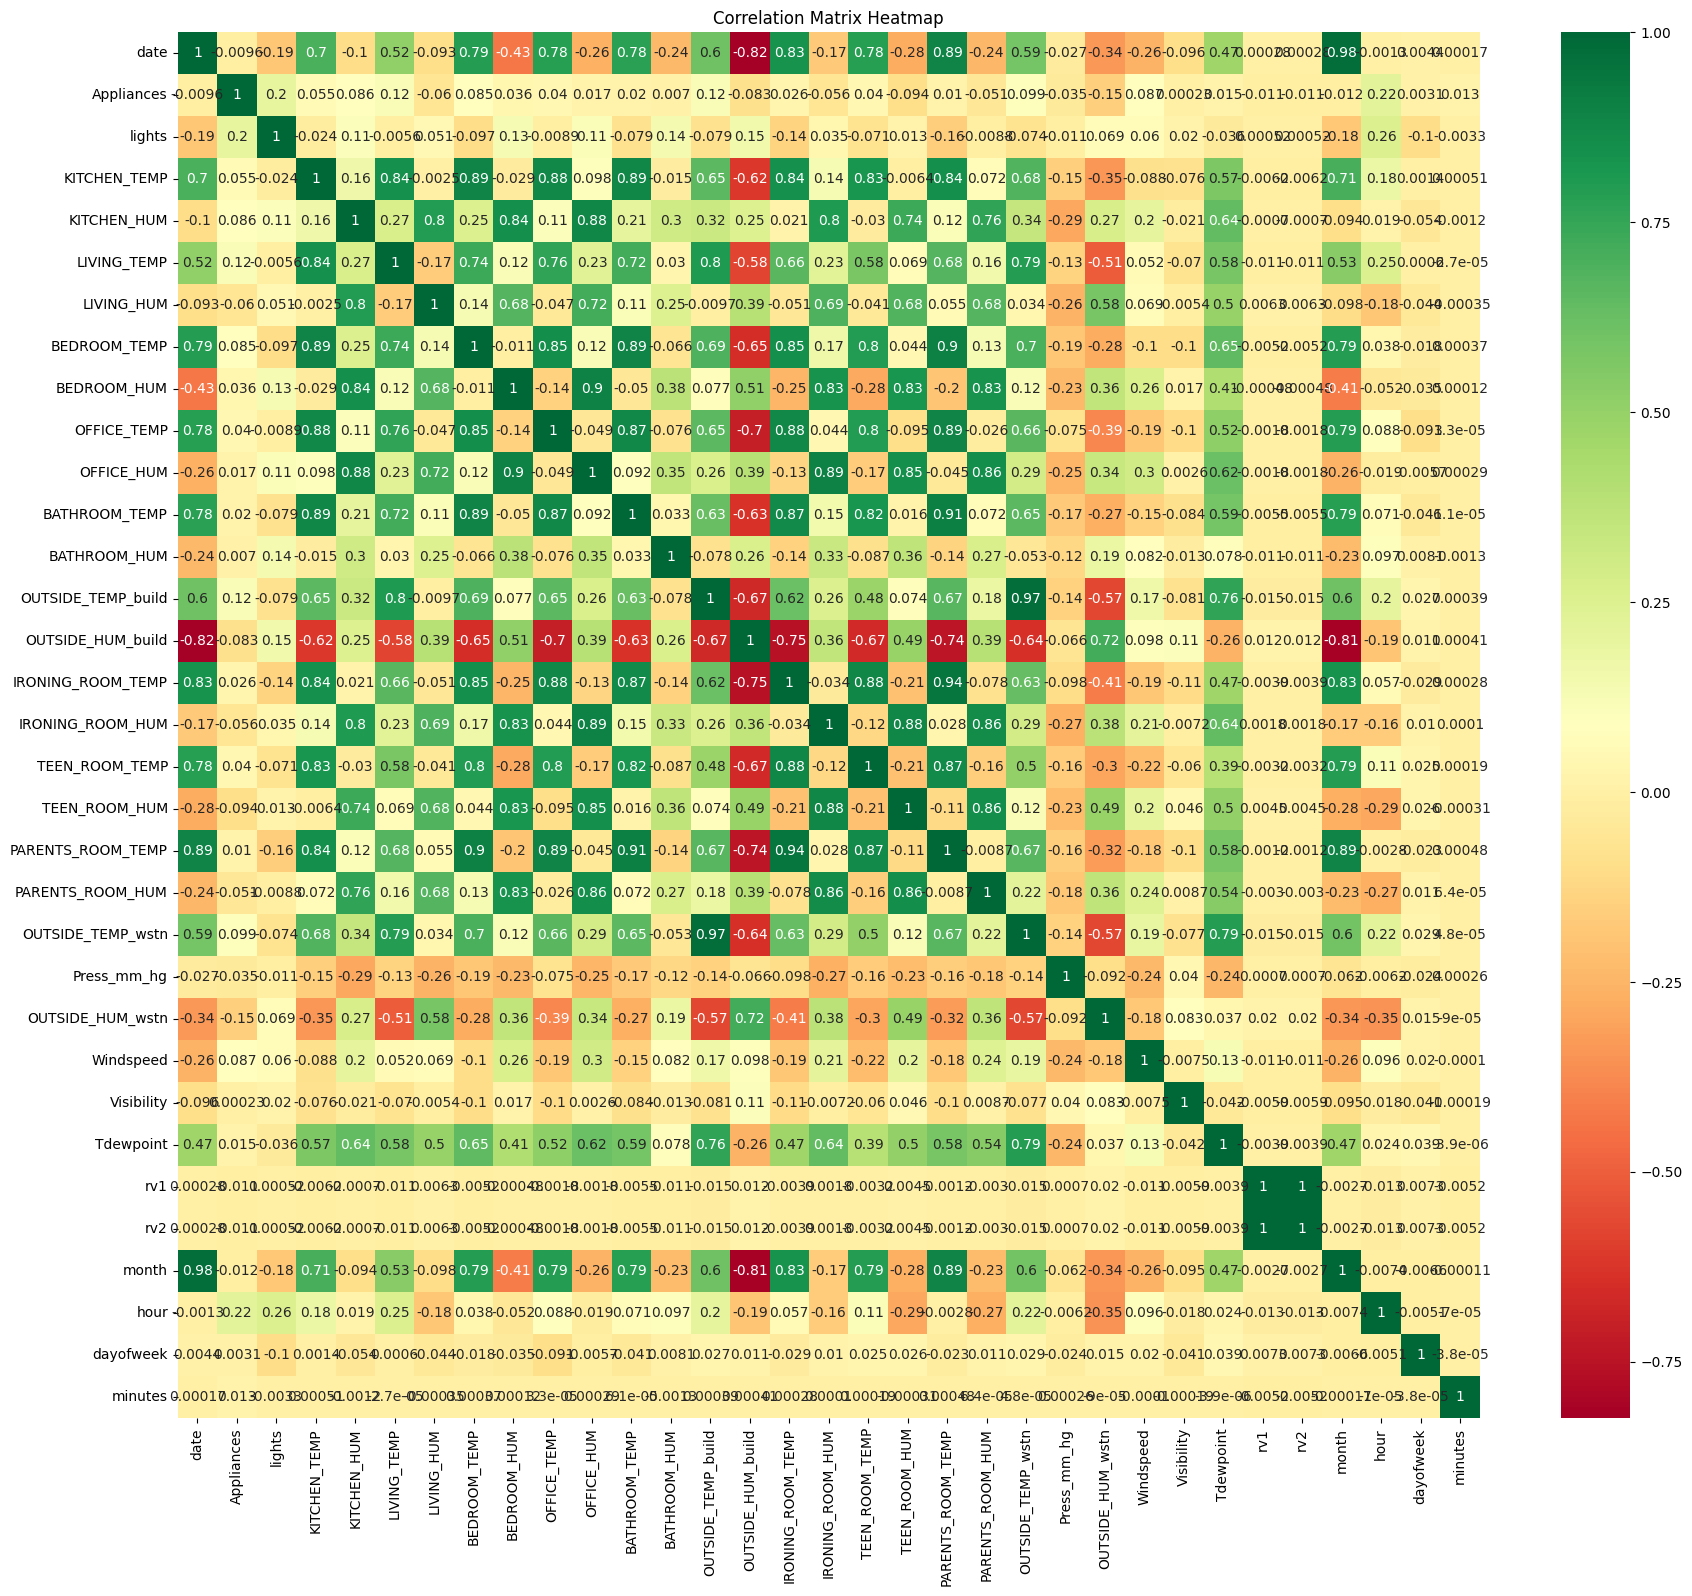

In [17]:
# Correlation mapping between variables

corr = data.corr()
plt.figure(figsize=(21, 18))
sns.heatmap(corr, annot=True, cmap="RdYlGn")
plt.title("Correlation Matrix Heatmap")

# Mask the repeated values
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.show()


In [18]:
# Pearson's Correlation between target and input variables

target = 'Appliances'  # Replace with your actual target variable column name
input_variables = data.columns.drop(target)

# Calculate the Pearson correlation between the target and input variables
correlations = data[input_variables].corrwith(data[target])

# Display the correlations
print("Pearson Correlation with Target Variable:")
print(correlations)

Pearson Correlation with Target Variable:
date                 -0.009630
lights                0.197278
KITCHEN_TEMP          0.055447
KITCHEN_HUM           0.086031
LIVING_TEMP           0.120073
LIVING_HUM           -0.060465
BEDROOM_TEMP          0.085060
BEDROOM_HUM           0.036292
OFFICE_TEMP           0.040281
OFFICE_HUM            0.016965
BATHROOM_TEMP         0.019760
BATHROOM_HUM          0.006955
OUTSIDE_TEMP_build    0.117638
OUTSIDE_HUM_build    -0.083178
IRONING_ROOM_TEMP     0.025801
IRONING_ROOM_HUM     -0.055642
TEEN_ROOM_TEMP        0.039572
TEEN_ROOM_HUM        -0.094039
PARENTS_ROOM_TEMP     0.010010
PARENTS_ROOM_HUM     -0.051462
OUTSIDE_TEMP_wstn     0.099155
Press_mm_hg          -0.034885
OUTSIDE_HUM_wstn     -0.152282
Windspeed             0.087122
Visibility            0.000230
Tdewpoint             0.015353
rv1                  -0.011145
rv2                  -0.011145
month                -0.011606
hour                  0.216792
dayofweek             0.0030

In [19]:
# Spearman Correlation for monotonic relationship
spearman_corr = data.corr(method='spearman')

# Get the correlation with the target variable
spearman_target_corr = spearman_corr['Appliances'].sort_values(ascending=False)

# Display the correlations
print("Spearman Correlation with Target Variable:")
print(spearman_target_corr)

Spearman Correlation with Target Variable:
Appliances            1.000000
hour                  0.416649
LIVING_TEMP           0.305091
lights                0.302420
KITCHEN_TEMP          0.244049
OUTSIDE_TEMP_build    0.242477
TEEN_ROOM_TEMP        0.236147
BEDROOM_TEMP          0.216852
OUTSIDE_TEMP_wstn     0.215504
OFFICE_TEMP           0.207153
BATHROOM_TEMP         0.185846
IRONING_ROOM_TEMP     0.181876
PARENTS_ROOM_TEMP     0.166976
date                  0.131050
month                 0.125885
Windspeed             0.112320
Tdewpoint             0.075221
KITCHEN_HUM           0.060519
dayofweek             0.032684
minutes               0.001069
Visibility           -0.003546
rv1                  -0.009289
rv2                  -0.009289
OFFICE_HUM           -0.020233
BATHROOM_HUM         -0.044904
BEDROOM_HUM          -0.057066
Press_mm_hg          -0.096176
IRONING_ROOM_HUM     -0.119409
LIVING_HUM           -0.119736
PARENTS_ROOM_HUM     -0.164553
TEEN_ROOM_HUM        -0.217

In [20]:
#Statistical Summary
data.describe(include='all').transpose()

,count,mean,min,25%,50%,75%,max,std
date,19735,2016-03-20 05:30:00,2016-01-11 17:00:00,2016-02-14 23:15:00,2016-03-20 05:30:00,2016-04-23 11:45:00,2016-05-27 18:00:00,NaN
Appliances,19735.0,97.694958,10.0,50.0,60.0,100.0,1080.0,102.524891
lights,19735.0,3.801875,0.0,0.0,0.0,0.0,70.0,7.935988
KITCHEN_TEMP,19735.0,21.686571,16.79,20.76,21.6,22.6,26.26,1.606066
KITCHEN_HUM,19735.0,40.259739,27.023333,37.333333,39.656667,43.066667,63.36,3.979299
LIVING_TEMP,19735.0,20.341219,16.1,18.79,20.0,21.5,29.856667,2.192974
LIVING_HUM,19735.0,40.42042,20.463333,37.9,40.5,43.26,56.026667,4.069813
BEDROOM_TEMP,19735.0,22.267611,17.2,20.79,22.1,23.29,29.236,2.006111
BEDROOM_HUM,19735.0,39.2425,28.766667,36.9,38.53,41.76,50.163333,3.254576
OFFICE_TEMP,19735.0,20.855335,15.1,19.53,20.666667,22.1,26.2,2.042884


In [ ]:
data.loc[data['OUTSIDE_TEMP_build'] == -6 ] # to check how any records are present with outside_temp_build = -6


,date,Appliances,lights,KITCHEN_TEMP,KITCHEN_HUM,LIVING_TEMP,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_TEMP,...,OUTSIDE_HUM_wstn,Windspeed,Visibility,Tdewpoint,rv1,rv2,month,hour,dayofweek,minutes
1193,2016-01-19 23:50:00,40,0,19.79,38.7,18.89,39.03,19.2,39.09,18.6,...,93.5,1.0,60.333333,-5.383333,32.167158,32.167158,1,23,1,50


In [ ]:
outside_hum_30 = data.loc[data['OUTSIDE_HUM_build'] ==1] # checking the records for few values based on the statistical summary
print(outside_hum_30['OUTSIDE_HUM_build'])

12801    1.0
12802    1.0
12803    1.0
12804    1.0
12805    1.0
        ... 
19730    1.0
19731    1.0
19732    1.0
19733    1.0
19734    1.0
Name: OUTSIDE_HUM_build, Length: 1452, dtype: float64


In [ ]:
data.loc[data['Visibility'] < 20]
#print(outside_hum_30['OUTSIDE_HUM_build'])

,Appliances,lights,KITCHEN_TEMP,LIVING_TEMP,BEDROOM_TEMP,OFFICE_TEMP,BATHROOM_TEMP,OUTSIDE_TEMP_build,IRONING_ROOM_TEMP,TEEN_ROOM_TEMP,...,Visibility,rv1,rv2,month,hour,dayofweek,minutes,dayofweek_name,weekend_weekday,date
743,140,30,23.29,22.100000,22.463333,21.000000,18.890000,0.766667,20.066667,21.100000,...,18.333333,13.568605,13.568605,1,20,5,50,Saturday,Weekend,2016-01-16 20:50:00
744,110,30,23.29,22.100000,22.390000,21.000000,18.823333,0.966667,20.100000,21.100000,...,14.000000,10.261547,10.261547,1,21,5,0,Saturday,Weekend,2016-01-16 21:00:00
745,100,20,23.29,22.166667,22.290000,21.000000,18.790000,1.000000,20.100000,21.166667,...,15.500000,19.081607,19.081607,1,21,5,10,Saturday,Weekend,2016-01-16 21:10:00
746,100,30,23.29,22.200000,22.290000,21.066667,18.790000,1.066667,20.100000,21.200000,...,17.000000,23.627906,23.627906,1,21,5,20,Saturday,Weekend,2016-01-16 21:20:00
747,110,20,23.29,22.133333,22.200000,21.100000,18.790000,1.100000,20.033333,21.200000,...,18.500000,41.775897,41.775897,1,21,5,30,Saturday,Weekend,2016-01-16 21:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19527,90,0,23.60,22.395000,25.000000,23.390000,21.290000,11.500000,23.200000,23.700000,...,8.750000,15.333015,15.333015,5,7,3,30,Thursday,Weekday,2016-05-26 07:30:00
19528,70,0,23.60,23.116000,24.926667,23.500000,21.290000,12.200000,23.200000,23.633333,...,11.333333,43.318838,43.318838,5,7,3,40,Thursday,Weekday,2016-05-26 07:40:00
19529,130,0,23.60,23.595714,24.760000,23.500000,21.290000,13.126667,23.200000,23.600000,...,13.916667,29.342171,29.342171,5,7,3,50,Thursday,Weekday,2016-05-26 07:50:00
19530,360,0,23.60,24.294000,24.700000,23.500000,21.290000,14.033333,23.180000,23.600000,...,16.500000,49.489173,49.489173,5,8,3,0,Thursday,Weekday,2016-05-26 08:00:00


In [21]:
# Create a line plot to show the trend of energy consumption over time
import plotly.express as px

# Assuming you have a DataFrame 'data' with a datetime index
fig = px.line(data, x= 'date', y='Appliances', title='Energy Consumption of Appliances Over Time',color_discrete_sequence=['black'])
fig.update_xaxes(title_text='Date')#, tickangle=0)
fig.update_yaxes(title_text='Energy Consumption')
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background for the plot area
    paper_bgcolor='lightgrey',     # Light grey background for the entire figure
    font=dict(color='blue')        # Text color
)

# Show the Plotly figure
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [22]:
# Create a line plot to show the trend of energy consumption for first one week
import plotly.express as px

filtered_data = data.loc[data['date'] < '2016-01-18'] # filter week1 data
# Assuming you have a DataFrame 'data' with a datetime index
fig = px.line(filtered_data, x= 'date', y='Appliances', title='Energy Consumption of Appliances Over Time')
fig.update_xaxes(title_text='Week1', tickangle=-45)
fig.update_yaxes(title_text='Energy Consumption')

# Show the Plotly figure
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Feature Generation

In [8]:
# Create dayofweek_name column by mapping the day of the week values to their respective names

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['dayofweek_name'] = data['dayofweek'].map(lambda x: day_names[x])


In [9]:
# Create new feature weekend_weekday using dayofweek_name
data['weekend_weekday'] = np.where(data['dayofweek_name'].isin(['Saturday','Sunday']),'Weekend','Weekday')

In [26]:
data.loc[data['weekend_weekday'] == 'Weekend']

,date,Appliances,lights,KITCHEN_TEMP,KITCHEN_HUM,LIVING_TEMP,LIVING_HUM,BEDROOM_TEMP,BEDROOM_HUM,OFFICE_TEMP,...,Visibility,Tdewpoint,rv1,rv2,month,hour,dayofweek,minutes,dayofweek_name,weekend_weekday
618,2016-01-16 00:00:00,50,0,23.000000,40.000000,22.150000,38.790000,21.000000,41.90,21.200000,...,28.000000,1.900000,31.332742,31.332742,1,0,5,0,Saturday,Weekend
619,2016-01-16 00:10:00,50,0,22.890000,40.126667,22.100000,38.933333,21.000000,41.90,21.133333,...,29.000000,1.858333,2.868634,2.868634,1,0,5,10,Saturday,Weekend
620,2016-01-16 00:20:00,30,0,22.890000,40.200000,22.033333,39.000000,21.000000,41.90,21.000000,...,30.000000,1.816667,42.583382,42.583382,1,0,5,20,Saturday,Weekend
621,2016-01-16 00:30:00,20,0,22.790000,40.090000,22.000000,39.126667,21.000000,41.90,20.926667,...,31.000000,1.775000,10.632267,10.632267,1,0,5,30,Saturday,Weekend
622,2016-01-16 00:40:00,40,0,22.790000,40.163333,22.000000,39.260000,21.000000,41.90,20.760000,...,32.000000,1.733333,26.973101,26.973101,1,0,5,40,Saturday,Weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19045,2016-05-22 23:10:00,60,0,24.700000,48.933333,22.500000,50.590000,26.066667,45.29,23.926667,...,29.666667,11.066667,24.562516,24.562516,5,23,6,10,Sunday,Weekend
19046,2016-05-22 23:20:00,60,0,24.666667,48.833333,22.500000,50.590000,26.100000,45.29,23.890000,...,36.333333,11.033333,46.805940,46.805940,5,23,6,20,Sunday,Weekend
19047,2016-05-22 23:30:00,60,0,24.600000,48.700000,22.426667,50.530000,26.100000,45.29,23.890000,...,43.000000,11.000000,27.856251,27.856251,5,23,6,30,Sunday,Weekend
19048,2016-05-22 23:40:00,60,0,24.600000,48.590000,22.390000,50.560000,26.100000,45.29,23.890000,...,49.666667,10.966667,6.666652,6.666652,5,23,6,40,Sunday,Weekend


In [27]:
data['dayofweek_name']. unique() # check if the values are unique

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

In [28]:
# Create a bar plot to show the trend of energy consumption by Day of the Week
import plotly.express as px
App = data.groupby('dayofweek_name')['Appliances'].mean().reset_index()

# Convert 'dayofweek_name' to categorical with the specified order
App['dayofweek_name'] = pd.Categorical(App['dayofweek_name'], categories=day_names, ordered=True)
App = App.sort_values('dayofweek_name')

# Create a bar plot
fig = px.bar(App, x='dayofweek_name', y='Appliances', title='Average Energy Consumption of Appliances by Day of the Week')

# Update axis labels
fig.update_xaxes(title_text='Day of the Week', tickangle=-45)
fig.update_yaxes(title_text='Average Energy Consumption')
# Update figure size
fig.update_layout(height=600, width=600)
# Show the plot
fig.show()


In [29]:
# Create a line plot to show the trend of energy consumption by Day of the Week
# Assuming you have a DataFrame 'data' with a datetime index
fig = px.line(App, x= 'dayofweek_name', y='Appliances', title='Energy Consumption of Appliances Over Time')
fig.update_xaxes(title_text='Week1', tickangle=-45)
fig.update_yaxes(title_text='Energy Consumption')

# Show the Plotly figure
fig.show()

In [10]:
 # selecting numerical columns for box plot
numerical_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Print the numerical columns to verify
print("Numerical columns:", numerical_columns)

Numerical columns: ['Appliances', 'lights', 'KITCHEN_TEMP', 'KITCHEN_HUM', 'LIVING_TEMP', 'LIVING_HUM', 'BEDROOM_TEMP', 'BEDROOM_HUM', 'OFFICE_TEMP', 'OFFICE_HUM', 'BATHROOM_TEMP', 'BATHROOM_HUM', 'OUTSIDE_TEMP_build', 'OUTSIDE_HUM_build', 'IRONING_ROOM_TEMP', 'IRONING_ROOM_HUM', 'TEEN_ROOM_TEMP', 'TEEN_ROOM_HUM', 'PARENTS_ROOM_TEMP', 'PARENTS_ROOM_HUM', 'OUTSIDE_TEMP_wstn', 'Press_mm_hg', 'OUTSIDE_HUM_wstn', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'month', 'hour', 'dayofweek', 'minutes']


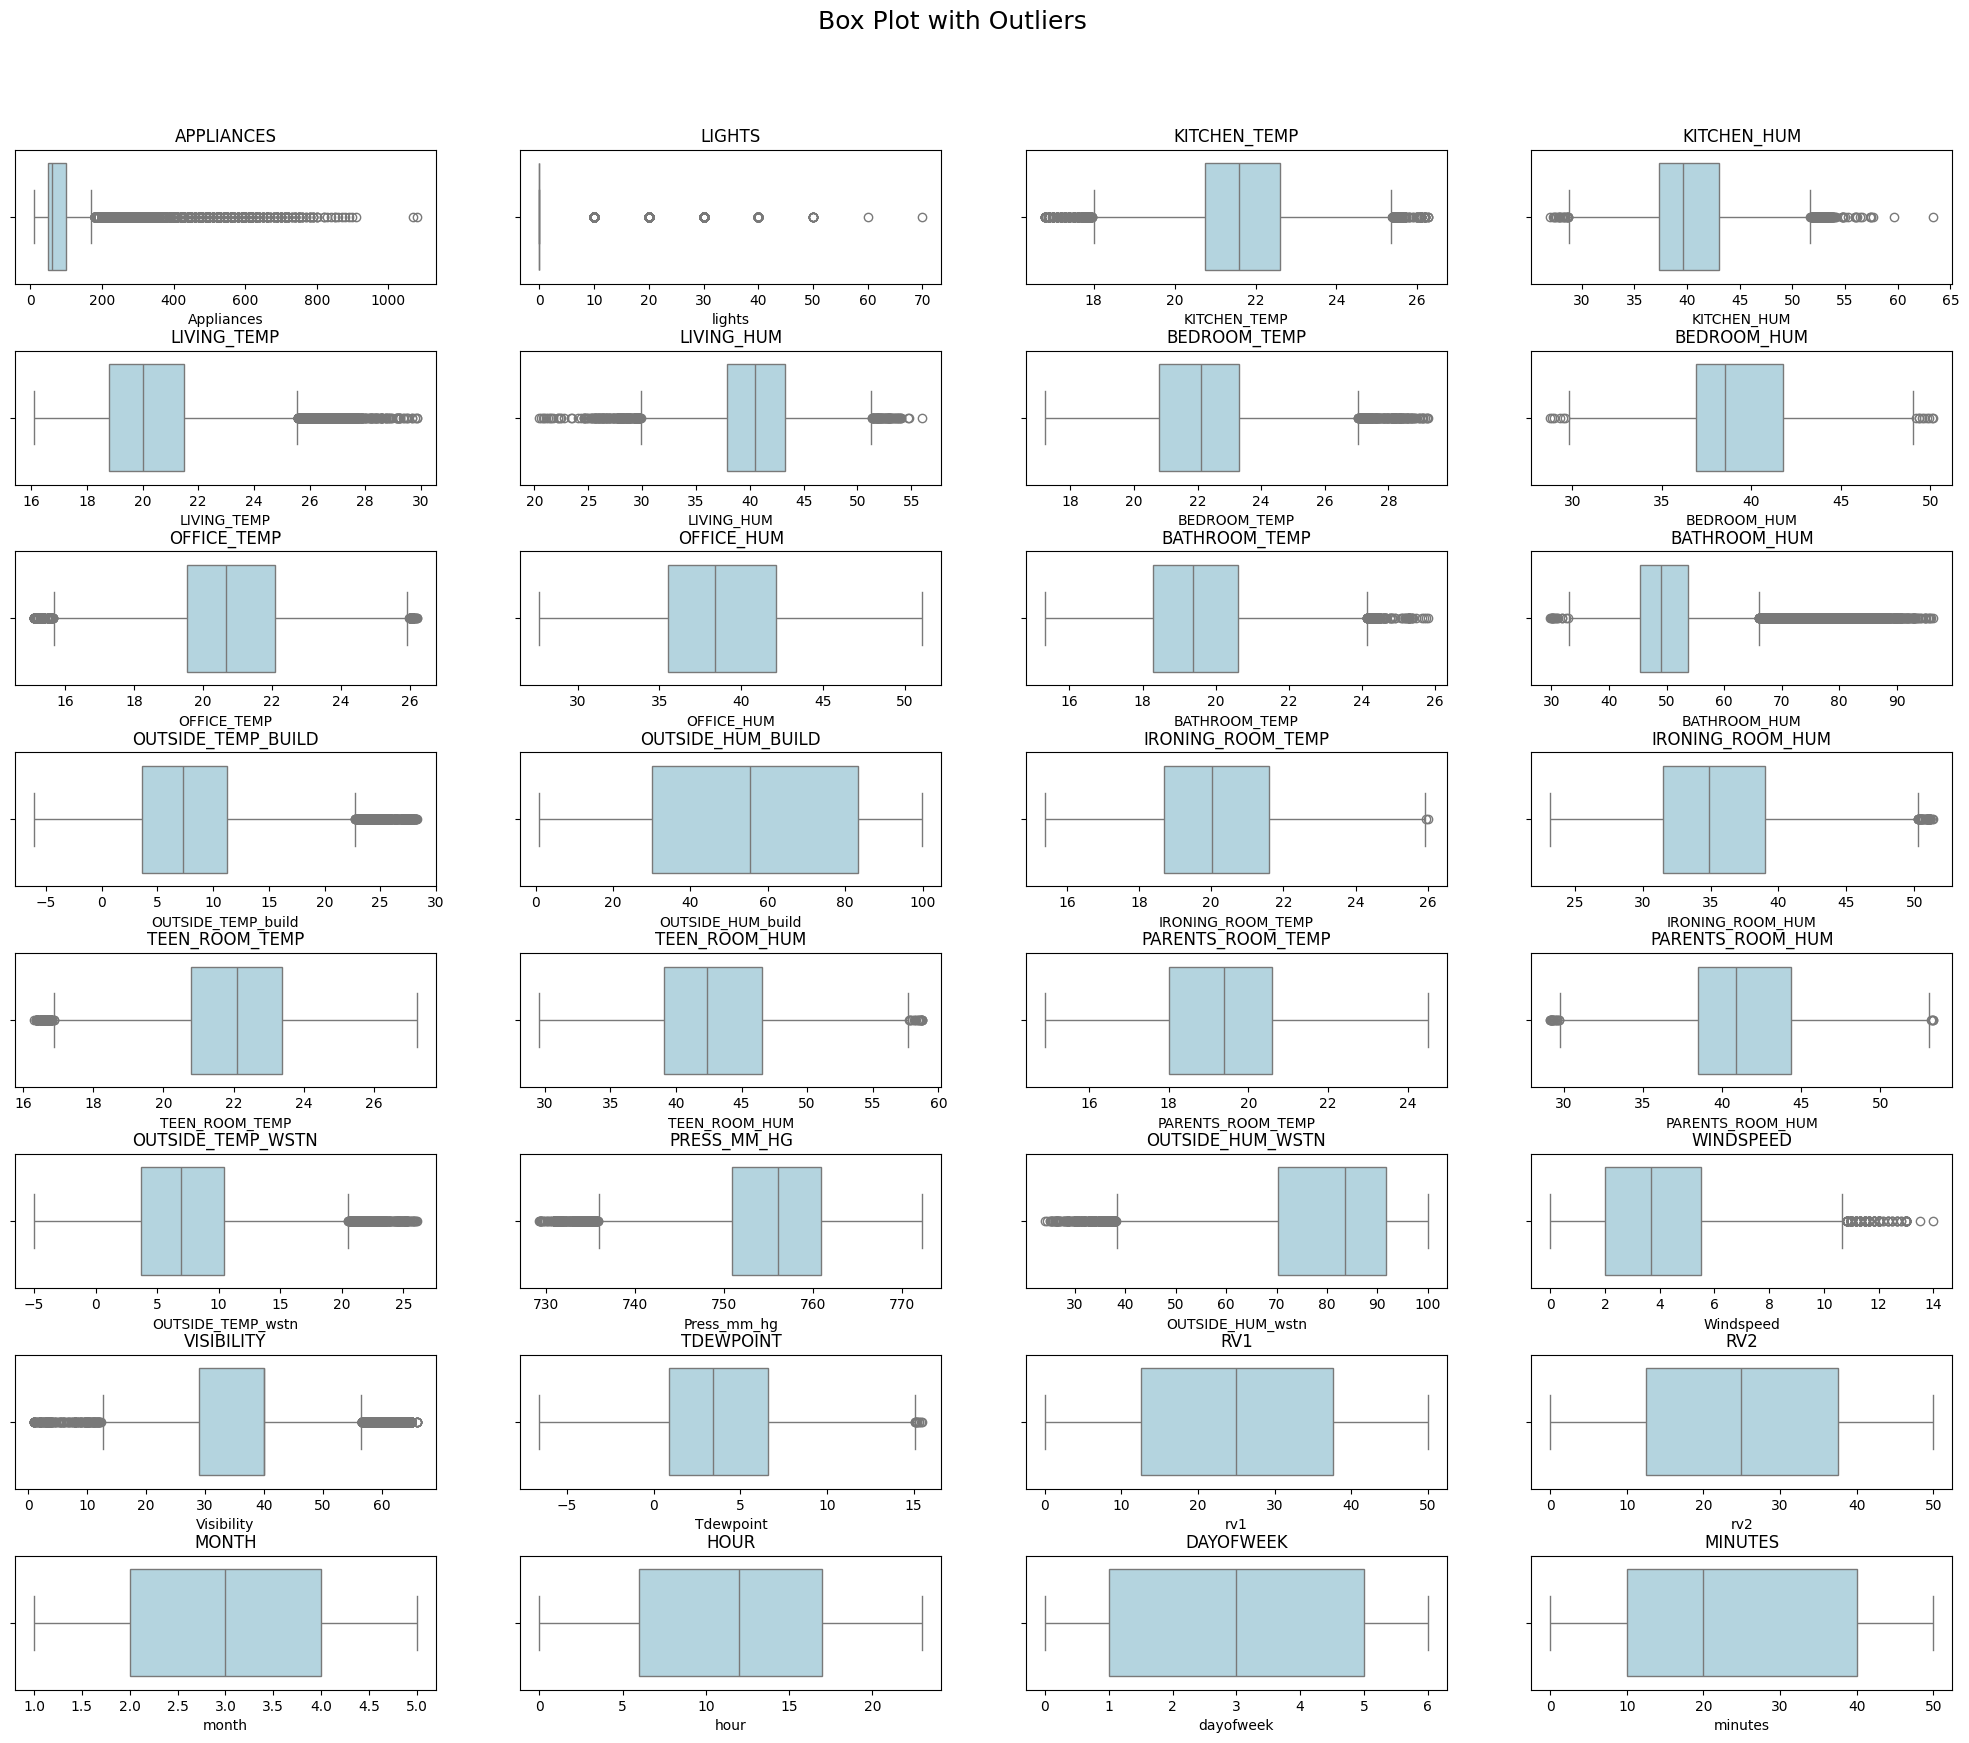

In [31]:
# Box Plot for detecting outliers

plt.figure(figsize=(25, 20))
plt.suptitle("Box Plot with Outliers", fontsize=18, y=0.95)
#plot the all figures in loop with boxplot
for n, ticker in enumerate(numerical_columns):

    ax = plt.subplot(8, 4, n + 1)

    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    sns.boxplot(x=data[ticker],color='lightblue' ,ax = ax)

    # chart formatting
    ax.set_title(ticker.upper())

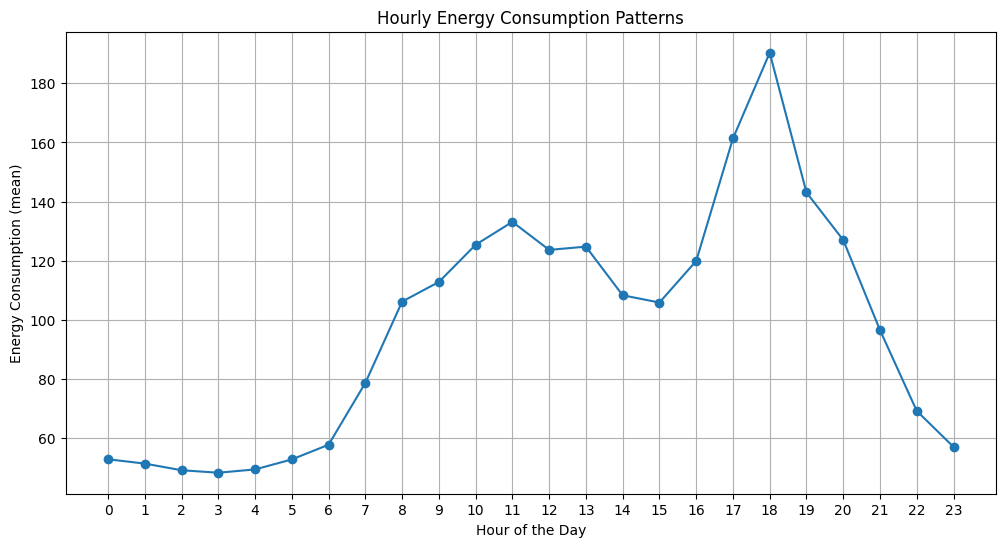

In [32]:
# Line graph plotting hourly energy consumption patterns

hourly_energy = data.groupby('hour')['Appliances'].mean()

# Create a line chart to visualize the hourly energy consumption patterns
plt.figure(figsize=(12, 6))
plt.plot(hourly_energy.index, hourly_energy.values, marker='o', linestyle='-')
plt.title('Hourly Energy Consumption Patterns')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption (mean)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

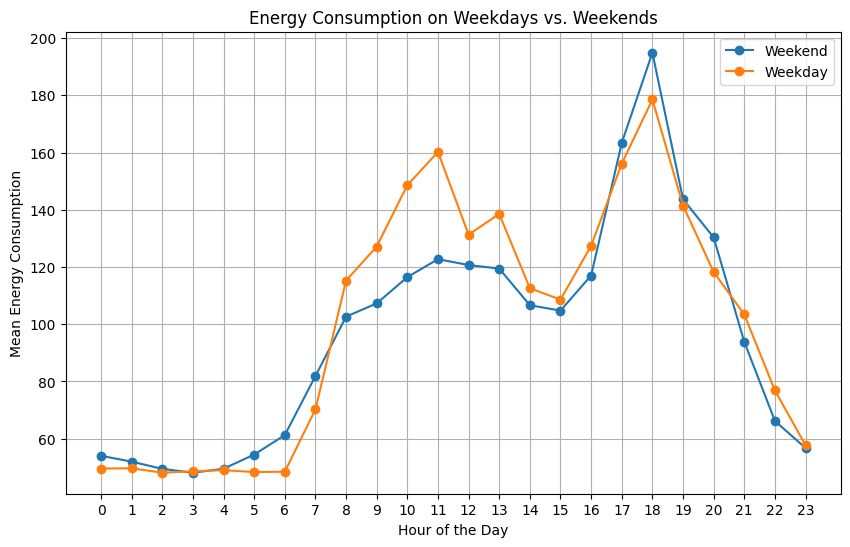

In [33]:
# Line graph plotting hourly energy consumption patterns during weekdays and weekend
plt.figure(figsize=(10, 6))

# Group the data by 'weekday' and calculate the mean energy consumption for weekdays and weekends
weekend_energy = data[data['weekend_weekday'] == 'Weekend'].groupby('hour')['Appliances'].mean()
weekday_energy = data[data['weekend_weekday'] != 'Weekend'].groupby('hour')['Appliances'].mean()

# Plot energy consumption for weekdays and weekends
plt.plot(weekday_energy.index, weekday_energy.values, label='Weekend', marker='o')
plt.plot(weekend_energy.index, weekend_energy.values, label='Weekday', marker='o')

plt.title('Energy Consumption on Weekdays vs. Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Energy Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend()

plt.show()

In [34]:
# Bar plot depicting weekday and weekend energy consumption

week_data = data.groupby('weekend_weekday')['Appliances'].mean().reset_index()

# Create a bar plot
fig = px.bar(week_data, x='weekend_weekday', y='Appliances', title='Average Energy Consumption of Appliances on Weekday/Weekend', width=400, height=500)

# Update axis labels
fig.update_xaxes(title_text='Weekday/Weekend', tickangle=-45)
fig.update_yaxes(title_text='Average Energy Consumption')
# Adjust the layout to ensure the title fits
fig.update_layout(
    title={'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': {'size': 12}},
    margin=dict(t=70)  # Increase top margin to make space for the title
)

# Show the plot
fig.show()

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Appliances'}>,
        <Axes: title={'center': 'lights'}>,
        <Axes: title={'center': 'KITCHEN_TEMP'}>,
        <Axes: title={'center': 'KITCHEN_HUM'}>,
        <Axes: title={'center': 'LIVING_TEMP'}>],
       [<Axes: title={'center': 'LIVING_HUM'}>,
        <Axes: title={'center': 'BEDROOM_TEMP'}>,
        <Axes: title={'center': 'BEDROOM_HUM'}>,
        <Axes: title={'center': 'OFFICE_TEMP'}>,
        <Axes: title={'center': 'OFFICE_HUM'}>,
        <Axes: title={'center': 'BATHROOM_TEMP'}>],
       [<Axes: title={'center': 'BATHROOM_HUM'}>,
        <Axes: title={'center': 'OUTSIDE_TEMP_build'}>,
        <Axes: title={'center': 'OUTSIDE_HUM_build'}>,
        <Axes: title={'center': 'IRONING_ROOM_TEMP'}>,
        <Axes: title={'center': 'IRONING_ROOM_HUM'}>,
        <Axes: title={'center': 'TEEN_ROOM_TEMP'}>],
       [<Axes: title={'center': 'TEEN_ROOM_HUM'}>,
        <Axes: title={'center': 'PARENTS_ROOM_T

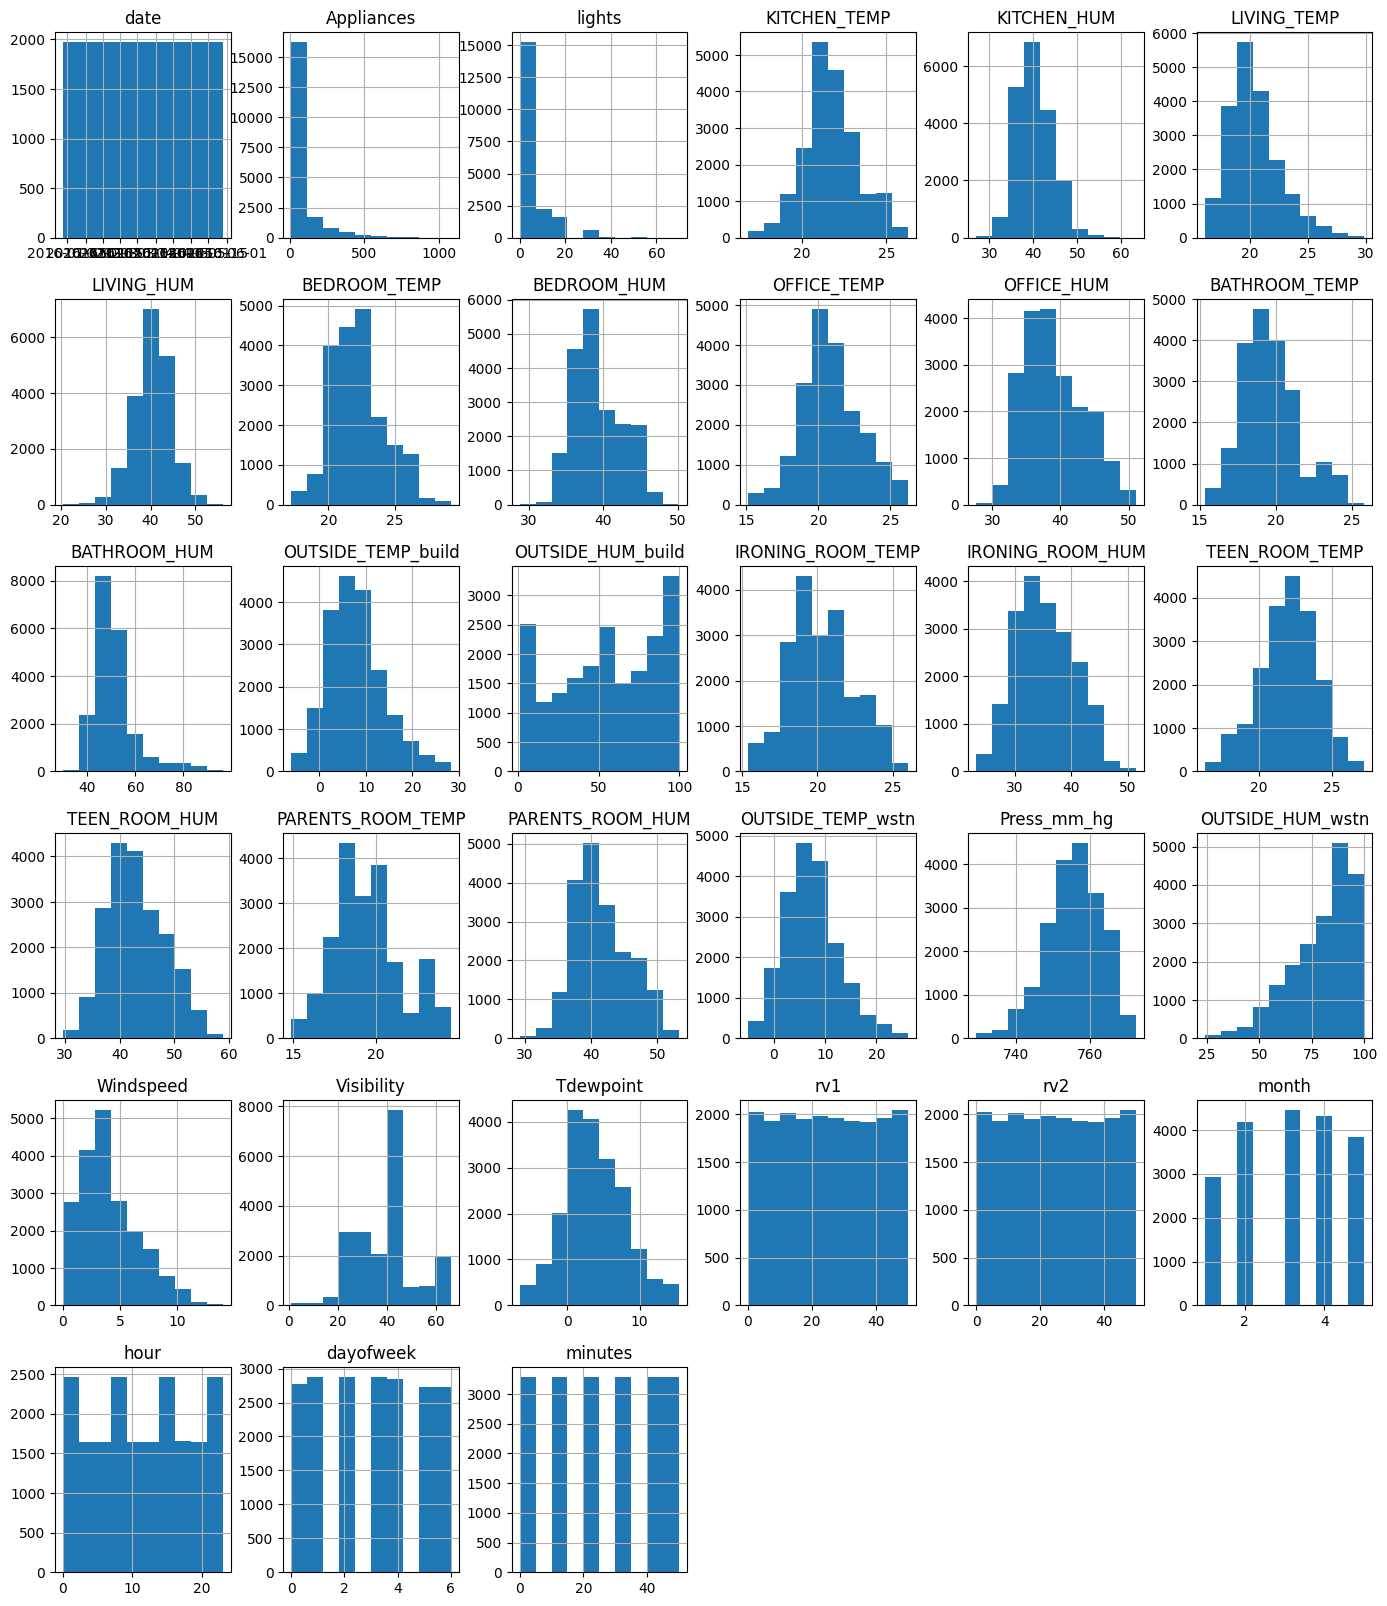

In [35]:
# Histogram to check the data distribution
data.hist(figsize=(17, 20), grid=True)

**Data Preprocessing**

In [36]:
# Check if null values are present
data.isnull().sum()

,0
date,0
Appliances,0
lights,0
KITCHEN_TEMP,0
KITCHEN_HUM,0
LIVING_TEMP,0
LIVING_HUM,0
BEDROOM_TEMP,0
BEDROOM_HUM,0
OFFICE_TEMP,0


In [37]:
#Check for NaN values
data.isna().sum()

,0
date,0
Appliances,0
lights,0
KITCHEN_TEMP,0
KITCHEN_HUM,0
LIVING_TEMP,0
LIVING_HUM,0
BEDROOM_TEMP,0
BEDROOM_HUM,0
OFFICE_TEMP,0


In [38]:
#Check for duplicates
data.duplicated().sum()

0

In [11]:
#reorder the columns
reorder = ['lights','KITCHEN_TEMP','LIVING_TEMP','BEDROOM_TEMP','OFFICE_TEMP','BATHROOM_TEMP','OUTSIDE_TEMP_build','IRONING_ROOM_TEMP','TEEN_ROOM_TEMP','PARENTS_ROOM_TEMP','OUTSIDE_TEMP_wstn',
                 'KITCHEN_HUM','LIVING_HUM','BEDROOM_HUM','OFFICE_HUM','BATHROOM_HUM','OUTSIDE_HUM_build','IRONING_ROOM_HUM','TEEN_ROOM_HUM','PARENTS_ROOM_HUM','OUTSIDE_HUM_wstn',
                 "Tdewpoint","Press_mm_hg","Windspeed","Visibility","rv1", "rv2",'month','hour','dayofweek','minutes','dayofweek_name','weekend_weekday','date','Appliances']

# Creating the DataFrame
data = data.reindex(columns=reorder)

In [12]:
#identify the outliers using IQR (InterQuatile Range)

def find_outliers_IQR(data):
    # Calculate the first quartile (Q1) and third quartile (Q3) for each column
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    # Calculate the interquartile range (IQR) for each column
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers for each column
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check for outliers in each column and count the number of outliers
    outliers_count = ((data < lower_bound) | (data > upper_bound)).sum()

    return outliers_count


outliers_per_column = find_outliers_IQR(data[numerical_columns]) # function call
print("Number of outliers per column:")
print(outliers_per_column.sort_values(ascending = False)) # sort the values


Number of outliers per column:
lights                4483
Visibility            2522
Appliances            2138
BATHROOM_HUM          1330
LIVING_TEMP            546
KITCHEN_TEMP           515
OUTSIDE_TEMP_build     515
OUTSIDE_TEMP_wstn      436
OUTSIDE_HUM_wstn       239
LIVING_HUM             235
Press_mm_hg            219
BEDROOM_TEMP           217
Windspeed              214
OFFICE_TEMP            186
BATHROOM_TEMP          179
KITCHEN_HUM            146
TEEN_ROOM_TEMP          71
IRONING_ROOM_HUM        42
PARENTS_ROOM_HUM        21
TEEN_ROOM_HUM           17
BEDROOM_HUM             15
Tdewpoint               10
IRONING_ROOM_TEMP        2
PARENTS_ROOM_TEMP        0
OUTSIDE_HUM_build        0
OFFICE_HUM               0
rv1                      0
rv2                      0
month                    0
hour                     0
dayofweek                0
minutes                  0
dtype: int64


In [41]:
# Display the values below the lower bound values in each column
#to avoid updating extreme lower values with negative lower bound values.

def handle_outliers(data, col_list):
    outliers_info = {}
    for ftr in col_list:
        Q1 = np.percentile(data[ftr], 25)
        Q3 = np.percentile(data[ftr], 75)
        IQR = Q3 - Q1

        # Calculate the outlier cutoff points
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Identify outliers
        outliers_lower = data[ftr] < lower
        outliers_upper = data[ftr] > upper
        num_outliers = outliers_lower.sum()

        print(f"Feature: {ftr}")
        print(f"Percentiles: 25th={Q1:.3f}, 75th={Q3:.3f}, IQR={IQR:.3f}")
        print(f"Lower bound: {lower}, Upper bound: {upper}")
        print(f"Identified outliers: {num_outliers}")

        # Store the outlier information
        outliers_info[ftr] = {
            'lower': lower,
            'upper': upper,
            'outliers_lower': outliers_lower,
            'outliers_upper': outliers_upper,
            'num_outliers': num_outliers
        }

        print("\n-------\n")

    return outliers_info

outliers_info = handle_outliers(data, numerical_columns)


Feature: Appliances
Percentiles: 25th=50.000, 75th=100.000, IQR=50.000
Lower bound: -25.0, Upper bound: 175.0
Identified outliers: 0

-------

Feature: lights
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Lower bound: 0.0, Upper bound: 0.0
Identified outliers: 0

-------

Feature: KITCHEN_TEMP
Percentiles: 25th=20.760, 75th=22.600, IQR=1.840
Lower bound: 18.0, Upper bound: 25.36
Identified outliers: 249

-------

Feature: KITCHEN_HUM
Percentiles: 25th=37.333, 75th=43.067, IQR=5.733
Lower bound: 28.733333333333185, Upper bound: 51.666666666666806
Identified outliers: 20

-------

Feature: LIVING_TEMP
Percentiles: 25th=18.790, 75th=21.500, IQR=2.710
Lower bound: 14.724999999999998, Upper bound: 25.565
Identified outliers: 0

-------

Feature: LIVING_HUM
Percentiles: 25th=37.900, 75th=43.260, IQR=5.360
Lower bound: 29.86, Upper bound: 51.3
Identified outliers: 167

-------

Feature: BEDROOM_TEMP
Percentiles: 25th=20.790, 75th=23.290, IQR=2.500
Lower bound: 17.04, Upper bound: 27.04
Ident

In [13]:
# Update the outliers with lower or upper bound values

def handle_outliers(data, col_list):
    outliers_info = {}
    for ftr in col_list:
        Q1 = np.percentile(data[ftr], 25)
        Q3 = np.percentile(data[ftr], 75)
        IQR = Q3 - Q1

        # Calculate the outlier cutoff points
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Identify outliers
        outliers_mask = (data[ftr] < lower) | (data[ftr] > upper)
        num_outliers = outliers_mask.sum()

        print(f"Feature: {ftr}")
        print(f"Percentiles: 25th={Q1:.3f}, 75th={Q3:.3f}, IQR={IQR:.3f}")
        print(f"Lower bound: {lower}, Upper bound: {upper}")
        print(f"Identified outliers: {num_outliers}")

        # Replace outliers with upper or lower bounds
        if num_outliers > 0 and ftr != 'lights':
            data.loc[outliers_mask, ftr] = np.clip(data.loc[outliers_mask, ftr], lower, upper)
            print(f"{num_outliers} outliers replaced with bounds ({lower}, {upper}) for {ftr}")

        print("\n-------\n")

    return outliers_info

outliers_info = handle_outliers(data, numerical_columns)


Feature: Appliances
Percentiles: 25th=50.000, 75th=100.000, IQR=50.000
Lower bound: -25.0, Upper bound: 175.0
Identified outliers: 2138
2138 outliers replaced with bounds (-25.0, 175.0) for Appliances

-------

Feature: lights
Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Lower bound: 0.0, Upper bound: 0.0
Identified outliers: 4483

-------

Feature: KITCHEN_TEMP
Percentiles: 25th=20.760, 75th=22.600, IQR=1.840
Lower bound: 18.0, Upper bound: 25.36
Identified outliers: 515
515 outliers replaced with bounds (18.0, 25.36) for KITCHEN_TEMP

-------

Feature: KITCHEN_HUM
Percentiles: 25th=37.333, 75th=43.067, IQR=5.733
Lower bound: 28.733333333333185, Upper bound: 51.666666666666806
Identified outliers: 146
146 outliers replaced with bounds (28.733333333333185, 51.666666666666806) for KITCHEN_HUM

-------

Feature: LIVING_TEMP
Percentiles: 25th=18.790, 75th=21.500, IQR=2.710
Lower bound: 14.724999999999998, Upper bound: 25.565
Identified outliers: 546
546 outliers replaced with bounds (14

In [43]:
# View the statistical summary after fixing the outliers
data.describe(include="all").transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
lights,19735.0,NaN,NaN,NaN,3.801875,0.0,0.0,0.0,0.0,70.0,7.935988
KITCHEN_TEMP,19735.0,NaN,NaN,NaN,21.689928,18.0,20.76,21.6,22.6,25.36,1.58021
LIVING_TEMP,19735.0,NaN,NaN,NaN,20.307042,16.1,18.79,20.0,21.5,25.565,2.093877
BEDROOM_TEMP,19735.0,NaN,NaN,NaN,22.259048,17.2,20.79,22.1,23.29,27.04,1.982974
OFFICE_TEMP,19735.0,NaN,NaN,NaN,20.85762,15.675,19.53,20.666667,22.1,25.955,2.035499
BATHROOM_TEMP,19735.0,NaN,NaN,NaN,19.589014,15.33,18.2775,19.39,20.619643,24.132857,1.836315
OUTSIDE_TEMP_build,19735.0,NaN,NaN,NaN,7.854457,-6.065,3.626667,7.3,11.256,22.7,5.936686
IRONING_ROOM_TEMP,19735.0,NaN,NaN,NaN,20.267103,15.39,18.7,20.033333,21.6,25.95,2.109985
TEEN_ROOM_TEMP,19735.0,NaN,NaN,NaN,22.030186,16.89,20.79,22.1,23.39,27.23,1.95322
PARENTS_ROOM_TEMP,19735.0,NaN,NaN,NaN,19.485828,14.89,18.0,19.39,20.6,24.5,2.014712


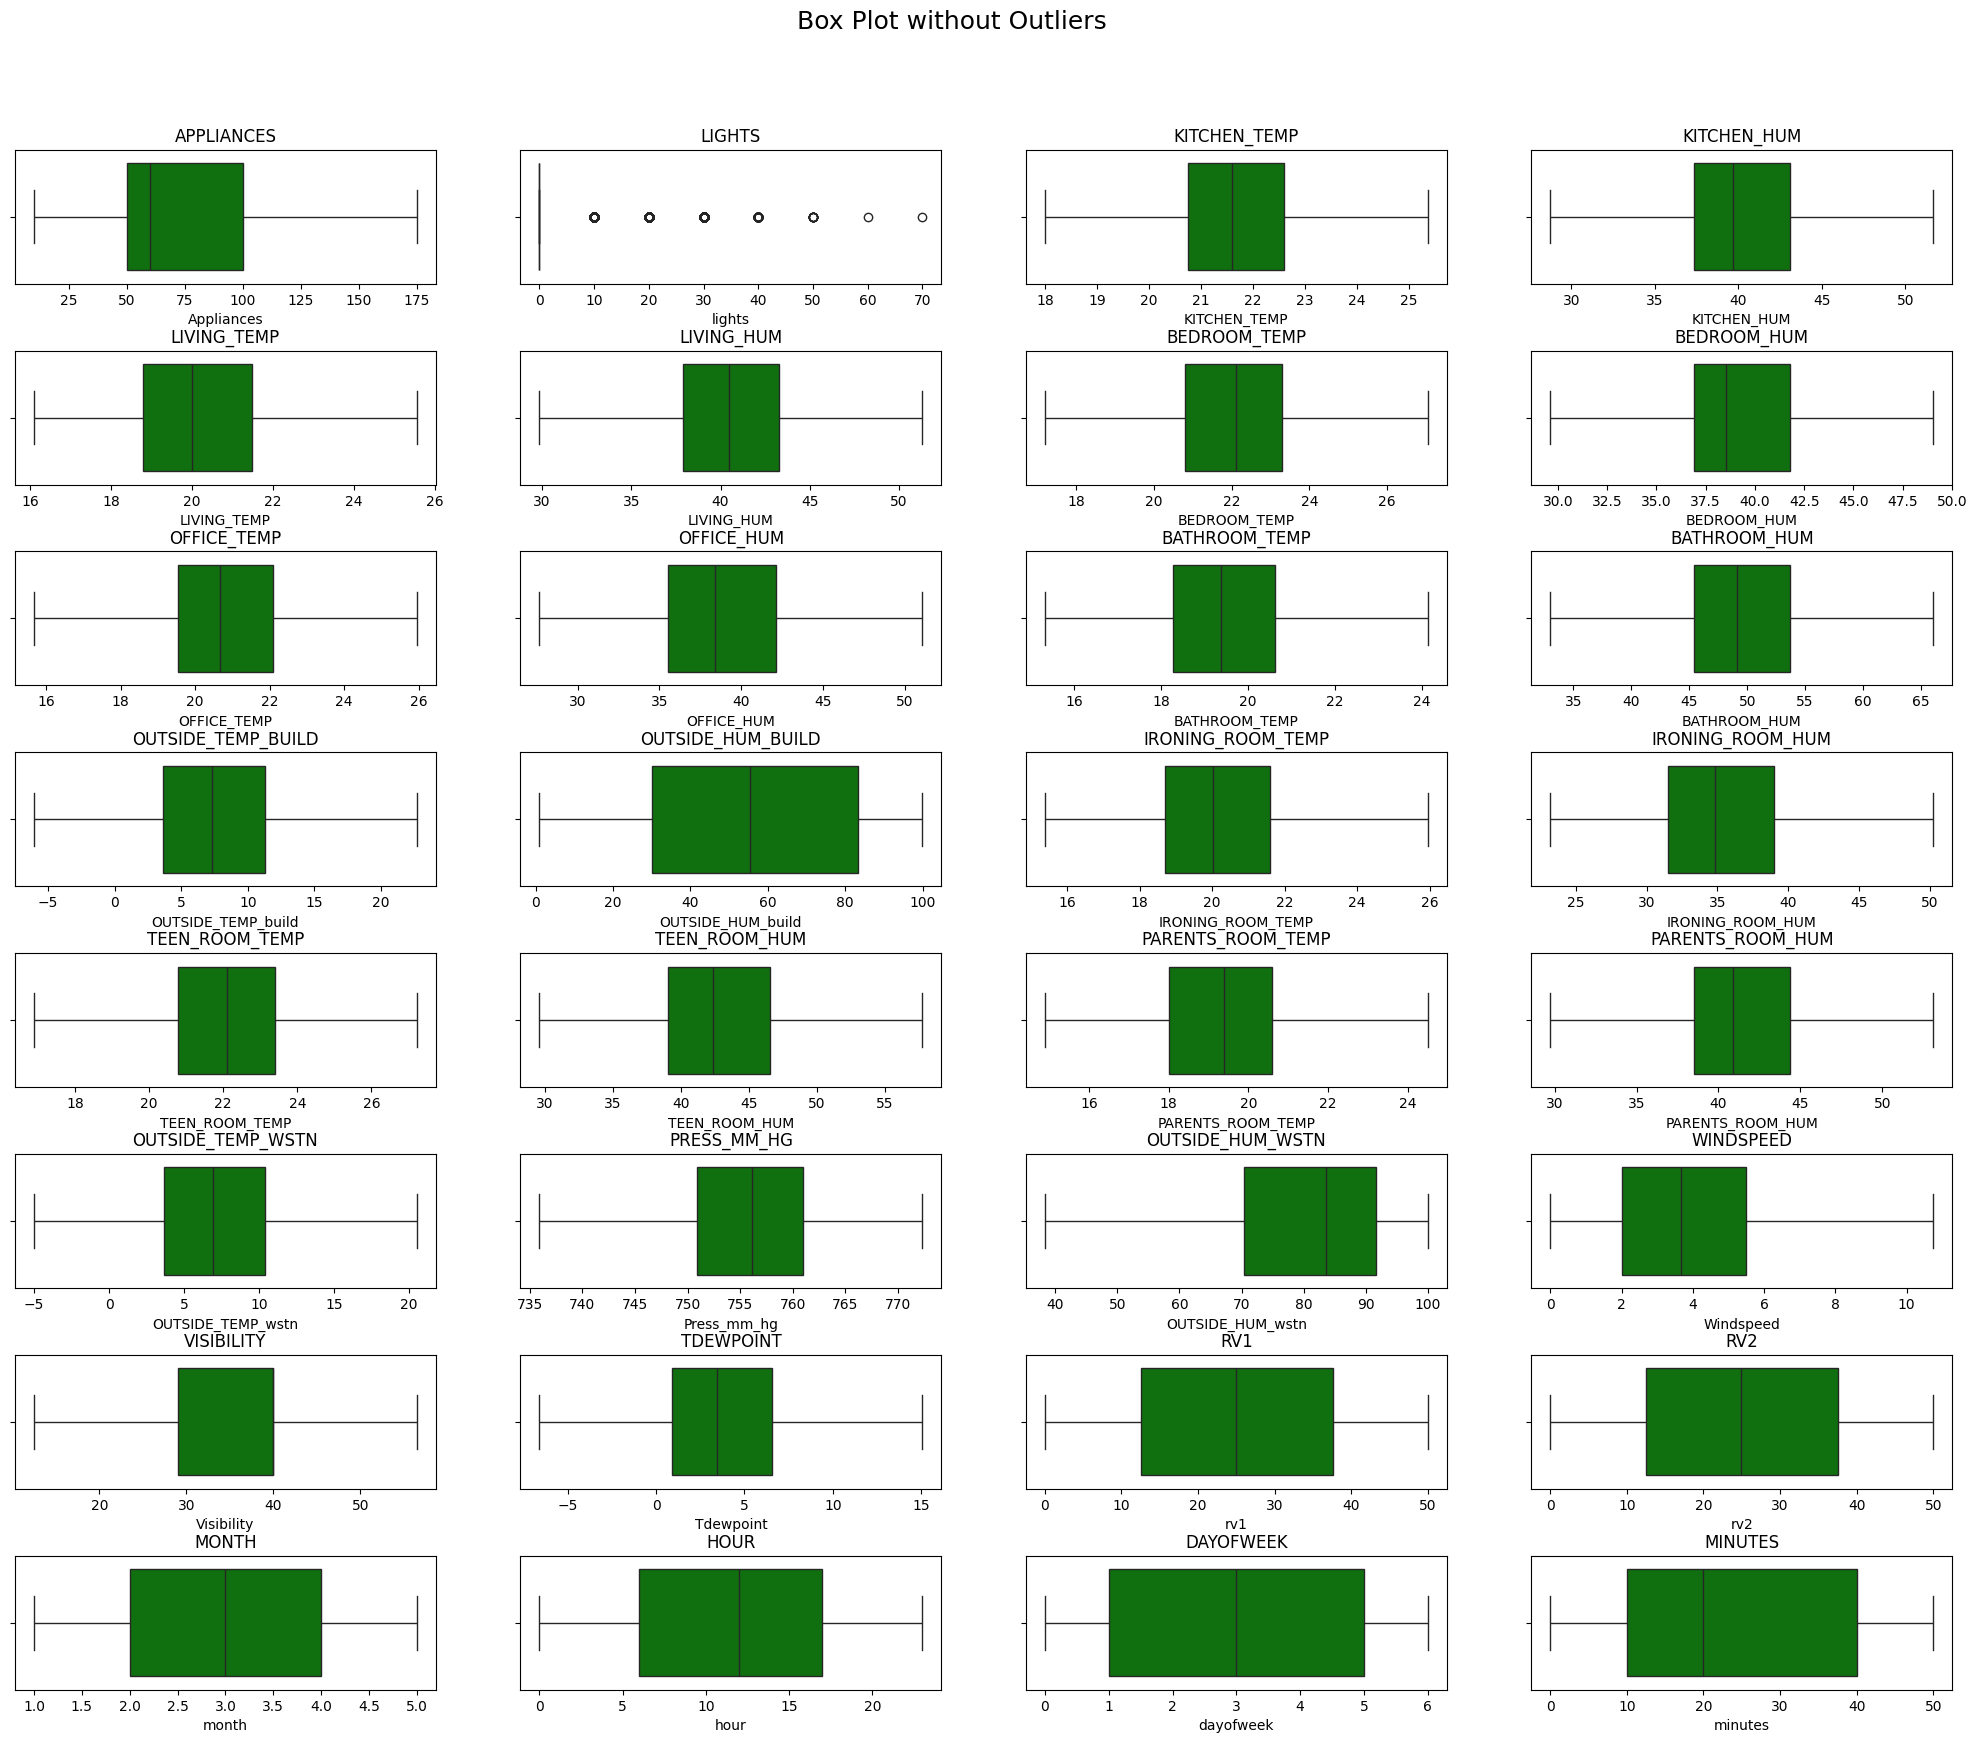

In [44]:
# Box-Plot depicting the columns after fixing outliers
plt.figure(figsize=(25, 20))
plt.suptitle("Box Plot without Outliers", fontsize=18, y=0.95)
#plot the all figures in loop with boxplot
for n, ticker in enumerate(numerical_columns):

    ax = plt.subplot(8, 4, n + 1)

    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    sns.boxplot(x=data[ticker],color='g' ,ax = ax)

    # chart formatting
    ax.set_title(ticker.upper())

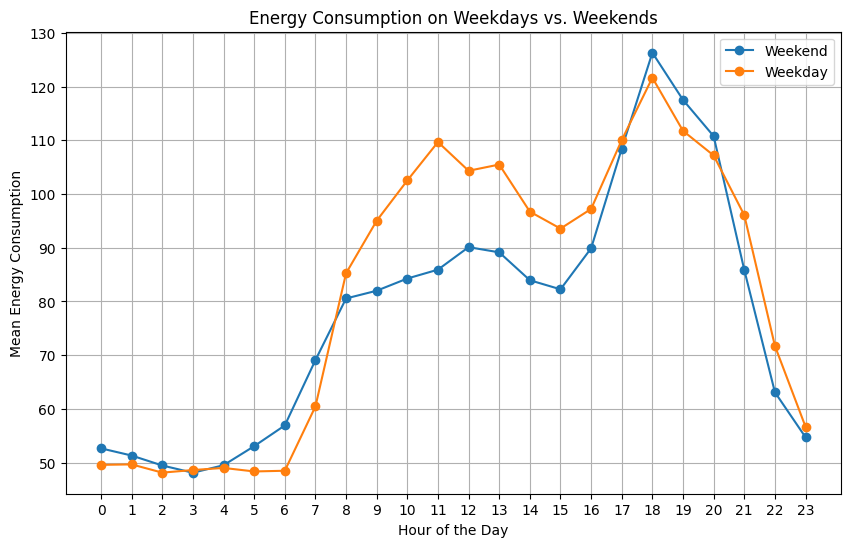

In [45]:
# Plot to check if any change in peak energy consumption hours after fixing outliers
plt.figure(figsize=(10, 6))

# Group the data by 'weekday' and calculate the mean energy consumption for weekdays and weekends
weekend_energy = data[data['weekend_weekday'] == 'Weekend'].groupby('hour')['Appliances'].mean()
weekday_energy = data[data['weekend_weekday'] != 'Weekend'].groupby('hour')['Appliances'].mean()

# Plot energy consumption for weekdays and weekends
plt.plot(weekday_energy.index, weekday_energy.values, label='Weekend', marker='o')
plt.plot(weekend_energy.index, weekend_energy.values, label='Weekday', marker='o')

plt.title('Energy Consumption on Weekdays vs. Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Energy Consumption')
plt.xticks(range(24))
plt.grid(True)
plt.legend()

plt.show()

In [14]:
# Copy the cleaned data into a new dataframe
data_df = data.copy()
data_df.shape

(19735, 35)

Model build Without Autoregression and PCA

In [15]:
#Split the cleaned data into train and test
# Split ratio 75:25

df_train = data_df.sample(frac=0.75, random_state=0)
df_test = data_df.drop(df_train.index)

In [16]:
# removed visibility, rv2, date as they have zero correlation with target variable
#select features for X_train-input and Y_train-target
selected_ftr = ['lights','KITCHEN_TEMP','LIVING_TEMP','BEDROOM_TEMP','OFFICE_TEMP','BATHROOM_TEMP','OUTSIDE_TEMP_build','IRONING_ROOM_TEMP','TEEN_ROOM_TEMP','PARENTS_ROOM_TEMP','OUTSIDE_TEMP_wstn',
                 'KITCHEN_HUM','LIVING_HUM','BEDROOM_HUM','OFFICE_HUM','BATHROOM_HUM','OUTSIDE_HUM_build','IRONING_ROOM_HUM','TEEN_ROOM_HUM','PARENTS_ROOM_HUM','OUTSIDE_HUM_wstn',
                 'Tdewpoint','Press_mm_hg','Windspeed','rv1','month','hour','dayofweek','minutes']

df_train_cln = pd.DataFrame(df_train)
X_trained = df_train_cln[selected_ftr]
y_trained = df_train_cln['Appliances']
X_trained.shape
y_trained.shape

(14801,)

In [17]:
#similarly for X_test and y_test
df_test_cln = pd.DataFrame(df_test)
X_tested = df_test_cln[selected_ftr]
y_tested = df_test_cln['Appliances']
X_tested.shape
y_tested.shape

(4934,)

In [18]:
print("X_Trained:", X_trained.shape, "X_Tested:",X_tested.shape )

X_Trained: (14801, 29) X_Tested: (4934, 29)


Data Transformation

In [19]:
# normalise the training data using standardscaler
ss_scaler = StandardScaler()
ss_scaler.fit(X_trained)
X_train_trans = ss_scaler.transform(X_trained)

In [20]:
# normalise test data
X_test_trans = ss_scaler.transform(X_tested)

Cross Validation specification

In [21]:
#Cross Validation specification
# Determine the splits
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

Model Development

Regression Models with original Variables without Autoregressive features and PCA

Linear Regression

In [54]:
# Hyperparameter tuning through Random SearchCV
lr_model= LinearRegression()
param_rs_lr = {'fit_intercept': [True, False],
              'copy_X': [True, False],
               'positive':[True, False],
             }
rs_lr = RandomizedSearchCV(lr_model,  param_distributions=param_rs_lr, n_iter =3,cv =kfold,scoring ='r2', random_state =42)
rs_lr.fit(X_train_trans, y_trained)
lr_bestModel = rs_lr.best_estimator_
print(lr_bestModel)
print(rs_lr.best_score_)
print(rs_lr.best_params_)

LinearRegression()
0.2898169423050364
{'positive': False, 'fit_intercept': True, 'copy_X': True}


In [55]:
#model fitting on train data
lr_model = LinearRegression(positive = False, fit_intercept= True, copy_X= True)
lr_model.fit(X_train_trans, y_trained)

LinearRegression()

In [ ]:
# Perform cross validation and prediction on test data

# Define the metrics for cross-validation
metrics_calculate = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

# Perform cross-validation and calculate the scores
score_lr = cross_validate(lr_model, X_train_trans, y_trained, cv=kfold, scoring=metrics_calculate)

# Calculate evaluation metrics for training predictions
lr_train_rmse = np.mean(np.sqrt(-score_lr['test_neg_mean_squared_error']))  # RMSE
lr_train_r2 = np.mean(score_lr['test_r2'])  # R2 Score
lr_train_mae = np.mean(-score_lr['test_neg_mean_absolute_error'])  # MAE
lr_train_mape = np.mean(-score_lr['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter() # start time of prediction

# Evaluate on the test set

y_pred_lr = lr_model.predict(X_test_trans)

time_elapsed = time.perf_counter() - start_time # end time of prediction

# Calculate evaluation metrics for test predictions
lr_test_rmse = np.sqrt(mean_squared_error(y_tested, y_pred_lr))
lr_test_r2 = r2_score(y_tested, y_pred_lr)
lr_test_mae = mean_absolute_error(y_tested, y_pred_lr)
lr_test_mape = mean_absolute_percentage_error(y_tested, y_pred_lr)

# Output results
print("LR_R2_Train:", lr_train_r2)
print("LR_R2_Test:", lr_test_r2)

print("\nLR_MAE_Train:", lr_train_mae)
print("LR_MAE_Test:", lr_test_mae)

print("\nLR_RMSE_Train:", lr_train_rmse)
print("LR_RMSE_Test:", lr_test_rmse)

print("\nLR_MAPE_Train:", lr_train_mape)
print("LR_MAPE_Test:", lr_test_mape)
print("Prediction Time:", str(time_elapsed))


LR_R2_Train: 0.28981694230503635
LR_R2_Test: 0.3212960404407663

LR_MAE_Train: 26.671956178118887
LR_MAE_Test: 25.911501700534863

LR_RMSE_Train: 36.21006644905085
LR_RMSE_Test: 35.258319450654376

LR_MAPE_Train: 0.3878151895006912
LR_MAPE_Test: 0.3743890133093743
Prediction Time: 0.0008408399999098037


Gradient Boosting Regressor

In [ ]:
# Model building with hyperparameter tuning
gbm_model_reg = GradientBoostingRegressor()
param_rs_gbm_reg = {'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
              'criterion' : ['friedman_mse', 'squared_error'],
              'n_estimators': [100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': [None, 'sqrt', 'log2'],
            'subsample': [0.7, 0.8, 0.9, 1.0]
               }
rs_gbm_reg = RandomizedSearchCV(gbm_model_reg,  param_distributions=param_rs_gbm_reg, n_iter=3,cv= kfold, scoring='r2',random_state =42)
rs_gbm_reg.fit(X_train_trans, y_trained)
gbm_reg_bestModel = rs_gbm_reg.best_estimator_
print(gbm_reg_bestModel)
print(rs_gbm_reg.best_score_)
print(rs_gbm_reg.best_params_)

GradientBoostingRegressor(learning_rate=0.2, loss='huber', min_samples_split=5,
                          subsample=0.7)
0.5157796454800272
{'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'loss': 'huber', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [57]:
#model fitting on entire train data
gbm_model_reg = GradientBoostingRegressor(subsample = 0.7, n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1, max_features= None,
                                          max_depth= 3, loss= 'huber', learning_rate= 0.2, criterion= 'friedman_mse')

gbm_model_reg.fit(X_train_trans, y_trained)

GradientBoostingRegressor(learning_rate=0.2, loss='huber', min_samples_split=5,
                          subsample=0.7)

In [ ]:
# Perform cross validation and prediction on test data
metrics_calculate = ['neg_mean_squared_error', 'r2','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
score_gbm = model_selection.cross_validate(gbm_model_reg, X_train_trans, y_trained, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for the training predictions

gbmr_train_rmse = np.mean(np.sqrt(-score_gbm['test_neg_mean_squared_error']))  # RMSE
gbmr_train_r2 = np.mean(score_gbm['test_r2'])  # R2 Score
gbmr_train_mae = np.mean(-score_gbm['test_neg_mean_absolute_error'])  # MAE
gbmr_train_mape = np.mean(-score_gbm['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()
# Evaluate on the test set
y_pred_gbmr = gbm_model_reg.predict(X_test_trans)

time_elapsed = time.perf_counter() - start_time
# Calculate evaluation metrics for the test predictions

gbmr_test_rmse = np.sqrt(mean_squared_error(y_tested, y_pred_gbmr))
gbmr_test_r2 = r2_score((y_tested),(y_pred_gbmr))
gbmr_test_mae = mean_absolute_error((y_tested),(y_pred_gbmr))
gbmr_test_mape = mean_absolute_percentage_error((y_tested),(y_pred_gbmr))

#output results
print("GBMR_R2_Train:", gbmr_train_r2)
print("GBMR_R2_Test:", gbmr_test_r2)

print("\nGBMR_RMSE_Train:" ,gbmr_train_rmse )
print("GBMR_RMSE_Test:" ,gbmr_test_rmse )

print("\nGBMR_MAE_Train:", gbmr_train_mae)
print("GBMR_MAE_Test:", gbmr_test_mae)

print("\nGBM_MAPE_Train:", gbmr_train_mape)
print("GBM_MAPE_Test:", gbmr_test_mape)
print("Prediction Time:", str(time_elapsed))

GBMR_R2_Train: 0.5185333943021401
GBMR_R2_Test: 0.5506309700130576

GBMR_RMSE_Train: 29.818379222844577
GBMR_RMSE_Test: 28.68950042420821

GBMR_MAE_Train: 20.242832196935762
GBMR_MAE_Test: 19.47654603160982

GBM_MAPE_Train: 0.27713230755793705
GBM_MAPE_Test: 0.2669637448757875
Prediction Time: 0.004770676000134699



Support Vector Machine Regressor

In [ ]:
# Model building with hyperparameter tuning
SVR_model_reg = SVR()
param_rs_svr_reg = { 'kernel': ['rbf','poly','sigmoid'],
                  'degree' : [3],
                   'gamma' : ['scale'],
                   'C': [0.1, 1, 10],
                   'epsilon': [0.1, 0.2, 0.3]
               }
rs_svr_reg = RandomizedSearchCV(SVR_model_reg, param_distributions = param_rs_svr_reg, n_iter=3,cv=kfold,scoring ='r2', random_state =42)
rs_svr_reg.fit(X_train_trans, y_trained)
svr_reg_bestModel = rs_svr_reg.best_estimator_
print(svr_reg_bestModel)
print(rs_svr_reg.best_score_)
print(rs_svr_reg.best_params_)

SVR(C=10, epsilon=0.3)
0.39950857999877193
{'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.3, 'degree': 3, 'C': 10}


In [58]:
# model fitting on entire training data
SVR_model_reg = SVR(C=10, epsilon=0.3, kernel = 'rbf', gamma = 'scale',degree =3 )
SVR_model_reg.fit(X_train_trans, y_trained)

SVR(C=10, epsilon=0.3)

In [ ]:
# Perform cross validation and prediction on test data
metrics_calculate = ['neg_mean_squared_error', 'r2','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
score_svr = model_selection.cross_validate(SVR_model_reg, X_train_trans, y_trained, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for training predictions

svre_train_rmse = np.mean(np.sqrt(-score_svr['test_neg_mean_squared_error']))  # RMSE
svre_train_r2 = np.mean(score_svr['test_r2'])  # R2 Score
svre_train_mae = np.mean(-score_svr['test_neg_mean_absolute_error'])  # MAE
svre_train_mape = np.mean(-score_svr['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()
# Evaluate on the test set
y_pred_svre = SVR_model_reg.predict(X_test_trans)
time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for test predictions

svre_test_rmse = np.sqrt(mean_squared_error(y_tested, y_pred_svre))
svre_test_r2 = r2_score((y_tested),(y_pred_svre))
svre_test_mae = mean_absolute_error((y_tested),(y_pred_svre))
svre_test_mape = mean_absolute_percentage_error((y_tested),(y_pred_svre))

#output results
print("SVRE_R2_Train:", svre_train_r2)
print("SVRE_R2_Test:", svre_test_r2)

print("\nSVRE_MAE_Train:", svre_train_mae)
print("SVRE_MAE_Test:", svre_test_mae)

print("\nSVRE_RMSE_Train:" ,svre_train_rmse )
print("SVRE_RMSE_Test:" ,svre_test_rmse )

print("\nSVRE_MAPE_Train:", svre_train_mape)
print("SVRE_MAPE_Test:", svre_test_mape)
print("Predicted Time:", str(time_elapsed))

SVRE_R2_Train: 0.3995085799987718
SVRE_R2_Test: 0.4250787059744574

SVRE_MAE_Train: 21.603244101369267
SVRE_MAE_Test: 20.992219873329816

SVRE_RMSE_Train: 33.3050914151438
SVRE_RMSE_Test: 32.450815411212446

SVRE_MAPE_Train: 0.2719785103880058
SVRE_MAPE_Test: 0.26394766619649
Predicted Time: 5.753165966999859


Random FOrest

In [ ]:
# Model building with hyperparameter tuning
rfr = RandomForestRegressor()
param_rfr = {'n_estimators' :  [50,100, 200],
              'criterion' : ['squared_error', 'friedman_mse'],
               'max_depth' : [None, 10, 20],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2, 5],
                'bootstrap': [True] }
rs_rfr = RandomizedSearchCV(rfr, param_distributions= param_rfr, n_iter=3,cv=kfold,scoring ='r2',random_state=42)
rs_rfr.fit(X_train_trans, y_trained)
rfr_bestModel = rs_rfr.best_estimator_
print(rfr_bestModel)
print(rs_rfr.best_score_)
print(rs_rfr.best_params_)

RandomForestRegressor(min_samples_split=5)
0.6943445873128073
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}


In [59]:
# Model fitting on entire training data
rfr = RandomForestRegressor(n_estimators= 100, min_samples_split= 5, min_samples_leaf= 1, max_depth= None, criterion= 'squared_error', bootstrap= True)
rfr.fit(X_train_trans, y_trained)

RandomForestRegressor(min_samples_split=5)

In [ ]:
# Perform cross validation and prediction on test data
metrics_calculate = ['neg_mean_squared_error', 'r2','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
score_rfr = model_selection.cross_validate(rfr, X_train_trans, y_trained, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for the training predictions

rfr_train_rmse = np.mean(np.sqrt(-score_rfr['test_neg_mean_squared_error']))  # RMSE
rfr_train_r2 = np.mean(score_rfr['test_r2'])  # R2 Score
rfr_train_mae = np.mean(-score_rfr['test_neg_mean_absolute_error'])  # MAE
rfr_train_mape = np.mean(-score_rfr['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()
# Evaluate the on test set
y_pred_rfr = rfr.predict(X_test_trans)

time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for the test predictions

rfr_test_rmse = np.sqrt(mean_squared_error(y_tested, y_pred_rfr))
rfr_test_r2 = r2_score((y_tested),(y_pred_rfr))
rfr_test_mae = mean_absolute_error((y_tested),(y_pred_rfr))
rfr_test_mape = mean_absolute_percentage_error((y_tested),(y_pred_rfr))

#output results
print("RFR_R2_Train:", rfr_train_r2)
print("RFR_R2_Test:", rfr_test_r2)

print("\nRFR_MAE_Train:", rfr_train_mae)
print("RFR_MAE_Test:", rfr_test_mae)

print("\nRFR_RMSE_Train:" ,rfr_train_rmse )
print("RFR_RMSE_Test:" ,rfr_test_rmse )

print("\nRFR_MAPE_Train:", rfr_train_mape)
print("RFRxl_MAPE_Test:", rfr_test_mape)
print("Prediction Time:", str(time_elapsed))

RFR_R2_Train: 0.6938065261097999
RFR_R2_Test: 0.7200209647192839

RFR_MAE_Train: 15.85599136775474
RFR_MAE_Test: 15.10826859047699

RFR_RMSE_Train: 23.767531856673042
RFR_RMSE_Test: 22.645617798191246

RFR_MAPE_Train: 0.22330510922078634
RFRxl_MAPE_Test: 0.21355562199492337
Prediction Time: 0.11265603300034854


***Implement Autoregressive Features on the original dataset - "data" ***

In [22]:
data_auto = data.copy()

In [23]:
# Using lambda function shift all records by one row  and assign to new variable data_shifted
#.i.e all records in 1st row will be shifted to second row and 1st row will have the value NaN for all columns

data_shifted = data_auto.apply(lambda x: x.shift(1))

print(data_shifted)

       lights  KITCHEN_TEMP  LIVING_TEMP  BEDROOM_TEMP  OFFICE_TEMP  \
0         NaN           NaN          NaN           NaN          NaN   
1        30.0         19.89       19.200         19.79    19.000000   
2        30.0         19.89       19.200         19.79    19.000000   
3        30.0         19.89       19.200         19.79    18.926667   
4        40.0         19.89       19.200         19.79    18.890000   
...       ...           ...          ...           ...          ...   
19730     0.0         25.36       25.565         27.04    24.700000   
19731     0.0         25.36       25.565         27.04    24.700000   
19732     0.0         25.36       25.565         27.04    24.700000   
19733    10.0         25.36       25.565         27.04    24.700000   
19734    10.0         25.36       25.414         26.89    24.700000   

       BATHROOM_TEMP  OUTSIDE_TEMP_build  IRONING_ROOM_TEMP  TEEN_ROOM_TEMP  \
0                NaN                 NaN                NaN         

In [24]:
# Replace the NaN value with 0
data_shifted = data_shifted.fillna(0)

In [25]:
# create Autoregressive features - new features with suffix _t-1 for all columns in data_auto
# assign the values in data_shifted to these new columns created
for col in data_auto.columns:
    data_auto[f'{col}_t-1'] = data_shifted[col]

print(data_auto.head())

   lights  KITCHEN_TEMP  LIVING_TEMP  BEDROOM_TEMP  OFFICE_TEMP  \
0      30         19.89         19.2         19.79    19.000000   
1      30         19.89         19.2         19.79    19.000000   
2      30         19.89         19.2         19.79    18.926667   
3      40         19.89         19.2         19.79    18.890000   
4      40         19.89         19.2         19.79    18.890000   

   BATHROOM_TEMP  OUTSIDE_TEMP_build  IRONING_ROOM_TEMP  TEEN_ROOM_TEMP  \
0      17.166667            7.026667          17.200000            18.2   
1      17.166667            6.833333          17.200000            18.2   
2      17.166667            6.560000          17.200000            18.2   
3      17.166667            6.433333          17.133333            18.1   
4      17.200000            6.366667          17.200000            18.1   

   PARENTS_ROOM_TEMP  ...    rv1_t-1    rv2_t-1  month_t-1  hour_t-1  \
0          17.033333  ...   0.000000   0.000000        0.0       0.0   
1 

In [26]:
#reorder the columns in data_auto
reorder2 = ['Appliances_t-1','lights_t-1','lights','KITCHEN_TEMP_t-1','KITCHEN_TEMP','LIVING_TEMP_t-1','LIVING_TEMP','BEDROOM_TEMP_t-1','BEDROOM_TEMP',
            'OFFICE_TEMP_t-1','OFFICE_TEMP','BATHROOM_TEMP_t-1','BATHROOM_TEMP','OUTSIDE_TEMP_build_t-1','OUTSIDE_TEMP_build','IRONING_ROOM_TEMP_t-1','IRONING_ROOM_TEMP',
            'TEEN_ROOM_TEMP_t-1','TEEN_ROOM_TEMP','PARENTS_ROOM_TEMP_t-1','PARENTS_ROOM_TEMP','OUTSIDE_TEMP_wstn_t-1','OUTSIDE_TEMP_wstn','KITCHEN_HUM_t-1',
                 'KITCHEN_HUM','LIVING_HUM_t-1','LIVING_HUM','BEDROOM_HUM_t-1','BEDROOM_HUM','OFFICE_HUM_t-1','OFFICE_HUM','BATHROOM_HUM_t-1','BATHROOM_HUM','OUTSIDE_HUM_build_t-1','OUTSIDE_HUM_build',
            'IRONING_ROOM_HUM_t-1','IRONING_ROOM_HUM','TEEN_ROOM_HUM_t-1','TEEN_ROOM_HUM','PARENTS_ROOM_HUM_t-1','PARENTS_ROOM_HUM','OUTSIDE_HUM_wstn_t-1','OUTSIDE_HUM_wstn',
               'Tdewpoint_t-1',  'Tdewpoint','Press_mm_hg_t-1','Press_mm_hg','Windspeed_t-1','Windspeed','rv1_t-1','rv1','month_t-1','month',
            'hour_t-1','hour','dayofweek_t-1','dayofweek','minutes_t-1','minutes','dayofweek_name_t-1','dayofweek_name','weekend_weekday_t-1','weekend_weekday','Visibility_t-1','Visibility','rv2_t-1', 'rv2','date_t-1','date','Appliances']

# Creating the DataFrame
data_auto = data_auto.reindex(columns=reorder2)

In [65]:
data_auto.tail()

,Appliances_t-1,lights_t-1,lights,KITCHEN_TEMP_t-1,KITCHEN_TEMP,LIVING_TEMP_t-1,LIVING_TEMP,BEDROOM_TEMP_t-1,BEDROOM_TEMP,OFFICE_TEMP_t-1,...,dayofweek_name,weekend_weekday_t-1,weekend_weekday,Visibility_t-1,Visibility,rv2_t-1,rv2,date_t-1,date,Appliances
19730,90.0,0.0,0,25.36,25.36,25.565,25.565000,27.04,27.040000,24.7,...,Friday,Weekday,Weekday,22.833333,23.666667,16.966162,43.096812,2016-05-27 17:10:00,2016-05-27 17:20:00,100
19731,100.0,0.0,0,25.36,25.36,25.565,25.565000,27.04,27.040000,24.7,...,Friday,Weekday,Weekday,23.666667,24.500000,43.096812,49.282940,2016-05-27 17:20:00,2016-05-27 17:30:00,90
19732,90.0,0.0,10,25.36,25.36,25.565,25.565000,27.04,27.040000,24.7,...,Friday,Weekday,Weekday,24.500000,25.333333,49.282940,29.199117,2016-05-27 17:30:00,2016-05-27 17:40:00,175
19733,175.0,10.0,10,25.36,25.36,25.565,25.414000,27.04,26.890000,24.7,...,Friday,Weekday,Weekday,25.333333,26.166667,29.199117,6.322784,2016-05-27 17:40:00,2016-05-27 17:50:00,175
19734,175.0,10.0,10,25.36,25.36,25.414,25.264286,26.89,26.823333,24.7,...,Friday,Weekday,Weekday,26.166667,27.000000,6.322784,34.118851,2016-05-27 17:50:00,2016-05-27 18:00:00,175


In [66]:
data_auto.head()

,Appliances_t-1,lights_t-1,lights,KITCHEN_TEMP_t-1,KITCHEN_TEMP,LIVING_TEMP_t-1,LIVING_TEMP,BEDROOM_TEMP_t-1,BEDROOM_TEMP,OFFICE_TEMP_t-1,...,dayofweek_name,weekend_weekday_t-1,weekend_weekday,Visibility_t-1,Visibility,rv2_t-1,rv2,date_t-1,date,Appliances
0,0.0,0.0,30,0.00,19.89,0.0,19.2,0.00,19.79,0.000000,...,Monday,0,Weekday,0.000000,56.500000,0.000000,13.275433,0,2016-01-11 17:00:00,60
1,60.0,30.0,30,19.89,19.89,19.2,19.2,19.79,19.79,19.000000,...,Monday,Weekday,Weekday,56.500000,56.500000,13.275433,18.606195,2016-01-11 17:00:00,2016-01-11 17:10:00,60
2,60.0,30.0,30,19.89,19.89,19.2,19.2,19.79,19.79,19.000000,...,Monday,Weekday,Weekday,56.500000,55.333333,18.606195,28.642668,2016-01-11 17:10:00,2016-01-11 17:20:00,50
3,50.0,30.0,40,19.89,19.89,19.2,19.2,19.79,19.79,18.926667,...,Monday,Weekday,Weekday,55.333333,51.500000,28.642668,45.410389,2016-01-11 17:20:00,2016-01-11 17:30:00,50
4,50.0,40.0,40,19.89,19.89,19.2,19.2,19.79,19.79,18.890000,...,Monday,Weekday,Weekday,51.500000,47.666667,45.410389,10.084097,2016-01-11 17:30:00,2016-01-11 17:40:00,60


In [46]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Appliances_t-1          19735 non-null  float64       
 1   lights_t-1              19735 non-null  float64       
 2   lights                  19735 non-null  int64         
 3   KITCHEN_TEMP_t-1        19735 non-null  float64       
 4   KITCHEN_TEMP            19735 non-null  float64       
 5   LIVING_TEMP_t-1         19735 non-null  float64       
 6   LIVING_TEMP             19735 non-null  float64       
 7   BEDROOM_TEMP_t-1        19735 non-null  float64       
 8   BEDROOM_TEMP            19735 non-null  float64       
 9   OFFICE_TEMP_t-1         19735 non-null  float64       
 10  OFFICE_TEMP             19735 non-null  float64       
 11  BATHROOM_TEMP_t-1       19735 non-null  float64       
 12  BATHROOM_TEMP           19735 non-null  float6

In [27]:
#Split data_auto into train and test data
df_train_1 = data_auto.sample(frac=0.75, random_state=0)
df_test_1 = data_auto.drop(df_train_1.index)
print("Training Data:",df_train_1.shape)
print("\nTesting Data:",df_test_1.shape)

Training Data: (14801, 70)

Testing Data: (4934, 70)


In [47]:
# Select features for X_train, Y_train, X_test, Y_test
# Removed date, rv2,rv2_t-1, visibility,dayofweek_name_t-1,dayofweek_name,weekend_weekday,weekend_weekday_t-1
selected_features = ['Appliances_t-1','lights_t-1','lights','KITCHEN_TEMP_t-1','KITCHEN_TEMP','LIVING_TEMP_t-1','LIVING_TEMP','BEDROOM_TEMP_t-1','BEDROOM_TEMP',
            'OFFICE_TEMP_t-1','OFFICE_TEMP','BATHROOM_TEMP_t-1','BATHROOM_TEMP','OUTSIDE_TEMP_build_t-1','OUTSIDE_TEMP_build','IRONING_ROOM_TEMP_t-1','IRONING_ROOM_TEMP',
            'TEEN_ROOM_TEMP_t-1','TEEN_ROOM_TEMP','PARENTS_ROOM_TEMP_t-1','PARENTS_ROOM_TEMP','OUTSIDE_TEMP_wstn_t-1','OUTSIDE_TEMP_wstn','KITCHEN_HUM_t-1',
                 'KITCHEN_HUM','LIVING_HUM_t-1','LIVING_HUM','BEDROOM_HUM_t-1','BEDROOM_HUM','OFFICE_HUM_t-1','OFFICE_HUM','BATHROOM_HUM_t-1','BATHROOM_HUM','OUTSIDE_HUM_build_t-1','OUTSIDE_HUM_build',
            'IRONING_ROOM_HUM_t-1','IRONING_ROOM_HUM','TEEN_ROOM_HUM_t-1','TEEN_ROOM_HUM','PARENTS_ROOM_HUM_t-1','PARENTS_ROOM_HUM','OUTSIDE_HUM_wstn_t-1','OUTSIDE_HUM_wstn',
               'Tdewpoint_t-1',  'Tdewpoint','Press_mm_hg_t-1','Press_mm_hg','Windspeed_t-1','Windspeed','rv1_t-1','rv1','month_t-1','month',
            'hour_t-1','hour','dayofweek_t-1','dayofweek','minutes_t-1','minutes']



df_train_clean = pd.DataFrame(df_train_1)
X_train = df_train_clean[selected_features]
y_train = df_train_clean['Appliances'] # Assigning target column
X_train.shape
y_train.shape

(14801,)

In [48]:
X_train.shape

(14801, 59)

In [49]:
y_train.shape

(14801,)

In [50]:
# Create X_test, Y_test from cleaned data and assign input and target features
df_test_clean = pd.DataFrame(df_test_1)
X_test = df_test_clean[selected_features]
y_test = df_test_clean['Appliances']
X_test.shape
y_test.shape

(4934,)

In [51]:
X_test.shape

(4934, 59)

In [52]:
y_test.shape

(4934,)

In [75]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14801 entries, 15563 to 19246
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Appliances_t-1          14801 non-null  float64
 1   lights_t-1              14801 non-null  float64
 2   lights                  14801 non-null  int64  
 3   KITCHEN_TEMP_t-1        14801 non-null  float64
 4   KITCHEN_TEMP            14801 non-null  float64
 5   LIVING_TEMP_t-1         14801 non-null  float64
 6   LIVING_TEMP             14801 non-null  float64
 7   BEDROOM_TEMP_t-1        14801 non-null  float64
 8   BEDROOM_TEMP            14801 non-null  float64
 9   OFFICE_TEMP_t-1         14801 non-null  float64
 10  OFFICE_TEMP             14801 non-null  float64
 11  BATHROOM_TEMP_t-1       14801 non-null  float64
 12  BATHROOM_TEMP           14801 non-null  float64
 13  OUTSIDE_TEMP_build_t-1  14801 non-null  float64
 14  OUTSIDE_TEMP_build      14801 non-null 

In [53]:
# normalise the training data using standardScaler
ss_scaler = StandardScaler()
ss_scaler.fit(X_train)
X_train_transformed = ss_scaler.transform(X_train)

In [54]:
# normalise test data
X_test_transformed = ss_scaler.transform(X_test)

In [36]:
# Assign the cross validation split value
# Determine the splits
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
# Define the metrics for cross-validation
metrics_calculate = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

Linear Regression with Autoregressive Features

In [ ]:
# Model training and hyperparameter tuning
lm_model = LinearRegression()
param_rs_lm = {'fit_intercept': [True, False],
              'copy_X': [True, False],
               'positive':[True, False]
             }
rs_lm = RandomizedSearchCV(lm_model, param_distributions=param_rs_lm, n_iter=3,cv=kfold,scoring ='r2',random_state = 42)
rs_lm.fit(X_train_transformed, y_train)
lm_bestModel = rs_lm.best_estimator_
print(lm_bestModel)
print(rs_lm.best_score_)
print(rs_lm.best_params_)

LinearRegression(positive=True)
0.712962382116185
{'positive': True, 'fit_intercept': True, 'copy_X': True}


In [79]:
# Fit the model on entire training data
lm_model = LinearRegression(positive=True, fit_intercept= True, copy_X= True)
lm_model.fit(X_train_transformed, y_train)

LinearRegression(positive=True)

In [ ]:
# Cross Validation and model prediction on test data

# Perform cross-validation and calculate the scores
score = cross_validate(lm_model, X_train_transformed, y_train, cv=kfold, scoring=metrics_calculate)

# Calculate evaluation metrics for training predictions
lm_train_rmse = np.mean(np.sqrt(-score['test_neg_mean_squared_error']))  # RMSE
lm_train_r2 = np.mean(score['test_r2'])  # R2 Score
lm_train_mae = np.mean(-score['test_neg_mean_absolute_error'])  # MAE
lm_train_mape = np.mean(-score['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()

# Evaluate the best model on test set
y_pred_lm = lm_model.predict(X_test_transformed)

time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for test predictions
lm_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lm))
lm_test_r2 = r2_score(y_test, y_pred_lm)
lm_test_mae = mean_absolute_error(y_test, y_pred_lm)
lm_test_mape = mean_absolute_percentage_error(y_test, y_pred_lm)

# Output results
print("LM_R2_Train:", lm_train_r2)
print("LM_R2_Test:", lm_test_r2)

print("\nLM_RMSE_Train:", lm_train_rmse)
print("LM_RMSE_Test:", lm_test_rmse)

print("\nLM_MAE_Train:", lm_train_mae)
print("LM_MAE_Test:", lm_test_mae)

print("\nLM_MAPE_Train:", lm_train_mape)
print("LM_MAPE_Test:", lm_test_mape)
print(" Time to predict: ",str(time_elapsed) )


LM_R2_Train: 0.712962382116185
LM_R2_Test: 0.7062166256804057

LM_RMSE_Train: 23.018799793749665
LM_RMSE_Test: 23.19717101404725

LM_MAE_Train: 14.618042463299645
LM_MAE_Test: 14.588187726765353

LM_MAPE_Train: 0.20744360038928827
LM_MAPE_Test: 0.20721222159223085
 Time to predict:  0.0012925849996463512


In [80]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 30.2 MB/s eta 0:00:00


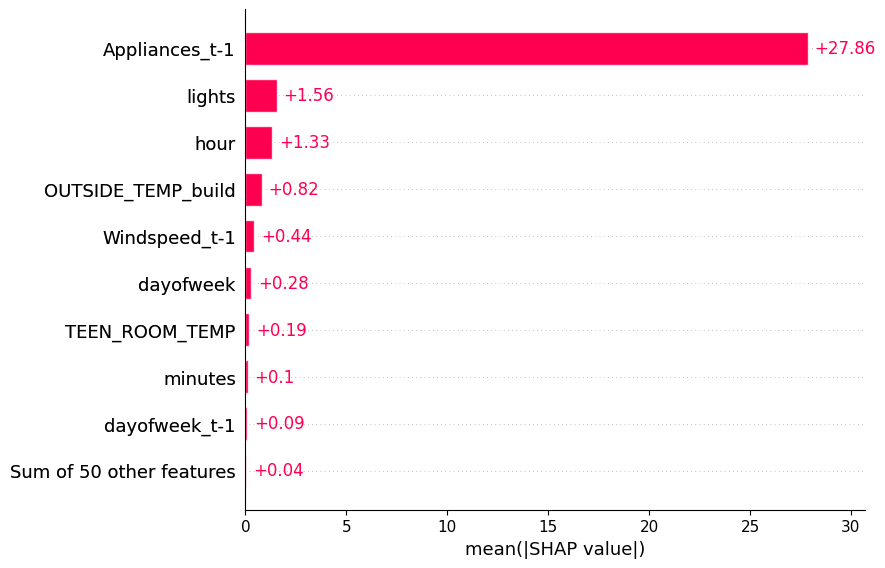

In [ ]:
# Shap Values
import shap
X_predictors = pd.DataFrame(X_train_transformed,columns = selected_features)
explainer = shap.LinearExplainer(lm_model,X_train_transformed)
shap_values = explainer(X_predictors)

# visualize the first prediction's explanation
shap.plots.bar(shap_values)

Gradient Boosting Regressor with Autoregressive features

In [ ]:
# Model training & fitting
gbm_model = GradientBoostingRegressor()
param_rs_gbm = {'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
              'criterion' : ['friedman_mse', 'squared_error'],
              'n_estimators': [100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': [None, 'sqrt', 'log2'],
            'subsample': [0.7, 0.8, 0.9, 1.0]
               }
rs_gbm = RandomizedSearchCV(gbm_model, param_distributions=param_rs_gbm, n_iter=3,cv=kfold,scoring='r2',random_state=42)
rs_gbm.fit(X_train_transformed, y_train)
gbm_bestModel = rs_gbm.best_estimator_
print(gbm_bestModel)
print(rs_gbm.best_score_)
print(rs_gbm.best_params_)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features='log2',
                          min_samples_leaf=5, subsample=0.9)
0.7217731372684544
{'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 4, 'loss': 'squared_error', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [81]:
gbm_model = GradientBoostingRegressor(n_estimators = 100, learning_rate=0.2, max_depth=4, max_features='log2',min_samples_leaf=5, subsample=0.9,
                                          min_samples_split = 2,loss= 'squared_error', criterion= 'friedman_mse' )
gbm_model.fit(X_train_transformed, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features='log2',
                          min_samples_leaf=5, subsample=0.9)

In [ ]:
# Cross validation and Model Prediction on test data
score_gbm = model_selection.cross_validate(gbm_model, X_train_transformed, y_train, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for training predictions

gbm_train_rmse = np.mean(np.sqrt(-score_gbm['test_neg_mean_squared_error']))  # RMSE
gbm_train_r2 = np.mean(score_gbm['test_r2'])  # R2 Score
gbm_train_mae = np.mean(-score_gbm['test_neg_mean_absolute_error'])  # MAE
gbm_train_mape = np.mean(-score_gbm['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()

# Evaluate the best model on test set
y_pred_gbm = gbm_model.predict(X_test_transformed)

time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for test predictions

gbm_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
gbm_test_r2 = r2_score((y_test),(y_pred_gbm))
gbm_test_mae = mean_absolute_error((y_test),(y_pred_gbm))
gbm_test_mape = mean_absolute_percentage_error((y_test),(y_pred_gbm))

#output results
print("GBM_R2_Train:", gbm_train_r2)
print("GBM_R2_Test:", gbm_test_r2)

print("\nGBM_RMSE_Train:" ,gbm_train_rmse )
print("GBM_RMSE_Test:" ,gbm_test_rmse )

print("\nGBM_MAE_Train:", gbm_train_mae)
print("GBM_MAE_Test:", gbm_test_mae)

print("\nGBM_MAPE_Train:", gbm_train_mape)
print("GBM_MAPE_Test:", gbm_test_mape)
print("Time to predict:", str(time_elapsed))

GBM_R2_Train: 0.7204043928779776
GBM_R2_Test: 0.7229009735793817

GBM_RMSE_Train: 22.715401207826858
GBM_RMSE_Test: 22.52884446797217

GBM_MAE_Train: 14.775609292618427
GBM_MAE_Test: 14.605754981317691

GBM_MAPE_Train: 0.21055400979961778
GBM_MAPE_Test: 0.20744418452764957
Time to predict: 0.008484081999995396


 97%|=================== | 14395/14801 [00:47<00:01]       

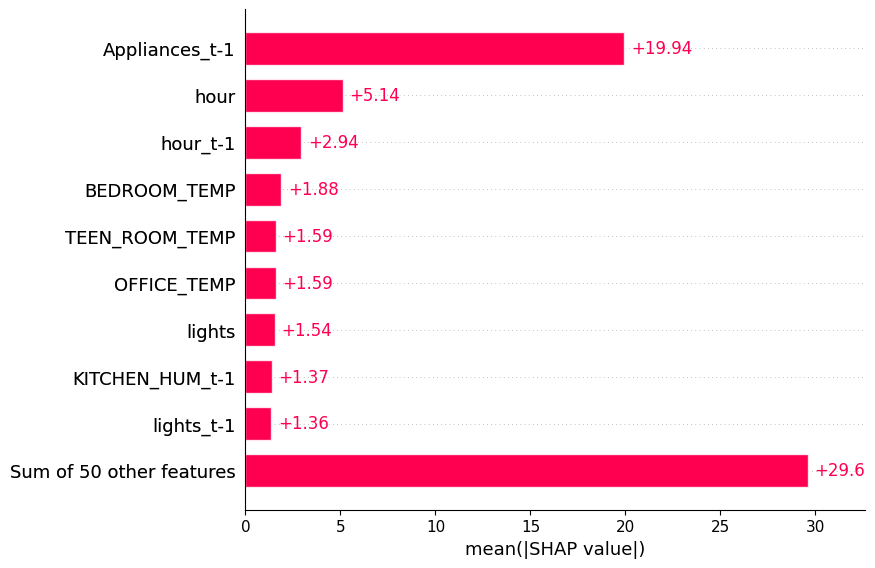

In [ ]:
#Shap values from GBM
import shap
X_predictors = pd.DataFrame(X_train_transformed,columns = selected_features)
explainer_gbm = shap.Explainer(gbm_model,X_predictors)
shap_values_gbm = explainer_gbm(X_predictors)
# visualize the first prediction's explanation
shap.plots.bar(shap_values_gbm)



**Support Vector Machine Regressor**

In [ ]:
# Model training and hyperparameter tuning
SVR_model = SVR()
param_rs_svr = { 'kernel': ['rbf', 'poly','sigmoid'],
                  'degree' : [3],
                   'gamma' : ['scale'],
                   'C': [0.1, 1, 10],
                   'epsilon': [0.1, 0.2, 0.3]
               }
rs_svr = RandomizedSearchCV(SVR_model, param_distributions=param_rs_svr, n_iter=3,cv=kfold,scoring='r2',random_state=42)
rs_svr.fit(X_train_transformed, y_train)
svr_bestModel = rs_svr.best_estimator_
print(svr_bestModel)
print(rs_svr.best_score_)
print(rs_svr.best_params_)

SVR(C=1)
0.6469087558876643
{'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'degree': 3, 'C': 1}


In [83]:
SVR_model = SVR(kernel= 'rbf', gamma= 'scale', epsilon= 0.1, degree= 3, C= 1)
SVR_model.fit(X_train_transformed,y_train)


SVR(C=1)

In [ ]:
# Cross Validation and model prediction on test data

score_svr = model_selection.cross_validate(SVR_model, X_train_transformed, y_train, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for training predictions

svr_train_rmse = np.mean(np.sqrt(-score_svr['test_neg_mean_squared_error']))  # RMSE
svr_train_r2 = np.mean(score_svr['test_r2'])  # R2 Score
svr_train_mae = np.mean(-score_svr['test_neg_mean_absolute_error'])  # MAE
svr_train_mape = np.mean(-score_svr['test_neg_mean_absolute_percentage_error'])  # MAPE

start_time = time.perf_counter()

# Evaluate on the test set
y_pred_svr = SVR_model.predict(X_test_transformed)

time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for test predictions

svr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_test_r2 = r2_score((y_test),(y_pred_svr))
svr_test_mae = mean_absolute_error((y_test),(y_pred_svr))
svr_test_mape = mean_absolute_percentage_error((y_test),(y_pred_svr))

#output results
print("SVR_R2_Train:", svr_train_r2)
print("SVR_R2_Test:", svr_test_r2)

print("\nSVR_MAE_Train:", svr_train_mae)
print("SVR_MAE_Test:", svr_test_mae)

print("\nSVR_RMSE_Train:" ,svr_train_rmse )
print("SVR_RMSE_Test:" ,svr_test_rmse )

print("\nSVR_MAPE_Train:", svr_train_mape)
print("SVR_MAPE_Test:", svr_test_mape)
print("Time to predict : ", str(time_elapsed))

SVR_R2_Train: 0.6469087558876643
SVR_R2_Test: 0.6504862663081812

SVR_MAE_Train: 16.640191111031662
SVR_MAE_Test: 16.22514972638112

SVR_RMSE_Train: 25.54035989509381
SVR_RMSE_Test: 25.301923573369105

SVR_MAPE_Train: 0.21532240348430004
SVR_MAPE_Test: 0.21054195127474443
Time to predict :  8.001542276000691


**Random Forest**

In [ ]:
# Model training with hyperparameters
rf = RandomForestRegressor()
param_rs_rf = {'n_estimators' :  [50,100, 200],
              'criterion' : ['squared_error', 'friedman_mse'],
               'max_depth' : [None, 10, 20],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2, 5],
                'bootstrap': [True] }
rs_rf = RandomizedSearchCV(rf, param_distributions=param_rs_rf, n_iter=3,cv=kfold, scoring ='r2',random_state=42)
rs_rf.fit(X_train_transformed, y_train)
rf_bestModel = rs_rf.best_estimator_
print(rf_bestModel)
print(rs_rf.best_score_)
print(rs_rf.best_params_)

RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_split=5, n_estimators=200)
0.7251039231543854
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'friedman_mse', 'bootstrap': True}


In [84]:
# fit the model
rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_depth = 10, criterion = 'friedman_mse', bootstrap = True)
rf.fit(X_train_transformed, y_train)

RandomForestRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_split=5, n_estimators=200)

In [ ]:
#cross validation and prediction on test data

metrics_calculate = ['neg_mean_squared_error', 'r2','neg_mean_absolute_error','neg_mean_absolute_percentage_error']
score_rf = model_selection.cross_validate(rf, X_train_transformed, y_train, cv=kfold, scoring=metrics_calculate)
# Calculate evaluation metrics for training predictions

rf_train_rmse = np.mean(np.sqrt(-score_rf['test_neg_mean_squared_error']))  # RMSE
rf_train_r2 = np.mean(score_rf['test_r2'])  # R2 Score
rf_train_mae = np.mean(-score_rf['test_neg_mean_absolute_error'])  # MAE
rf_train_mape = np.mean(-score_rf['test_neg_mean_absolute_percentage_error'])  # MAPE

# Start timing the prediction process
start_time = time.perf_counter()

# Make predictions on the test set using the trained model
y_pred_rf = rf.predict(X_test_transformed)

# Calculate the total time taken for prediction
time_elapsed = time.perf_counter() - start_time

# Calculate evaluation metrics for test predictions

rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_test_r2 = r2_score((y_test),(y_pred_rf))
rf_test_mae = mean_absolute_error((y_test),(y_pred_rf))
rf_test_mape = mean_absolute_percentage_error((y_test),(y_pred_rf))

#output results
print("RF_R2_Train:", rf_train_r2)
print("RF_R2_Test:", rf_test_r2)

print("\nRF_RMSE_Train:" ,rf_train_rmse )
print("RF_RMSE_Test:" ,rf_test_rmse )

print("\nRF_MAE_Train:", rf_train_mae)
print("RF_MAE_Test:", rf_test_mae)

print("\nRF_MAPE_Train:", rf_train_mape)
print("RF_MAPE_Test:", rf_test_mape)
print("Time elapsed:", str(time_elapsed))


RF_R2_Train: 0.724996331623825
RF_R2_Test: 0.7181175944186543

RF_RMSE_Train: 22.53693288757324
RF_RMSE_Test: 22.722462816110617

RF_MAE_Train: 14.11665626100545
RF_MAE_Test: 14.123400562801988

RF_MAPE_Train: 0.19909898176541452
RF_MAPE_Test: 0.19886737968246584
Time elapsed: 0.11022648800280876


In [86]:
# Print the important features obtained from Random Forest
print("Random Forest feature importances:", str(rf.feature_importances_))


Random Forest feature importances: [8.58431713e-01 1.79629672e-03 2.54097363e-03 1.74468537e-03
 1.88933031e-03 2.23219146e-03 2.52224500e-03 2.57776999e-03
 2.53747245e-03 2.15651944e-03 2.98588370e-03 2.32957830e-03
 2.46656598e-03 1.87863195e-03 1.61573240e-03 1.67947105e-03
 1.90806780e-03 2.99387681e-03 2.97207067e-03 1.73540874e-03
 1.74279632e-03 1.41602660e-03 1.25574964e-03 1.91018594e-03
 3.10181264e-03 2.03677635e-03 2.32315839e-03 2.14038239e-03
 2.44712173e-03 1.73417207e-03 1.53057923e-03 2.36295923e-03
 2.37765617e-03 2.14535023e-03 2.42863111e-03 1.71924566e-03
 2.01764096e-03 2.28438050e-03 2.75848951e-03 2.27503052e-03
 2.49803265e-03 2.14519746e-03 2.33483186e-03 2.11026079e-03
 2.10758108e-03 3.25284023e-03 3.58496291e-03 2.10440685e-03
 1.95051090e-03 6.98988870e-03 5.68543303e-03 1.65863501e-04
 1.36872201e-04 6.89332470e-03 1.13957320e-02 7.53194252e-04
 8.40758666e-04 1.03251264e-03 1.01516584e-03]


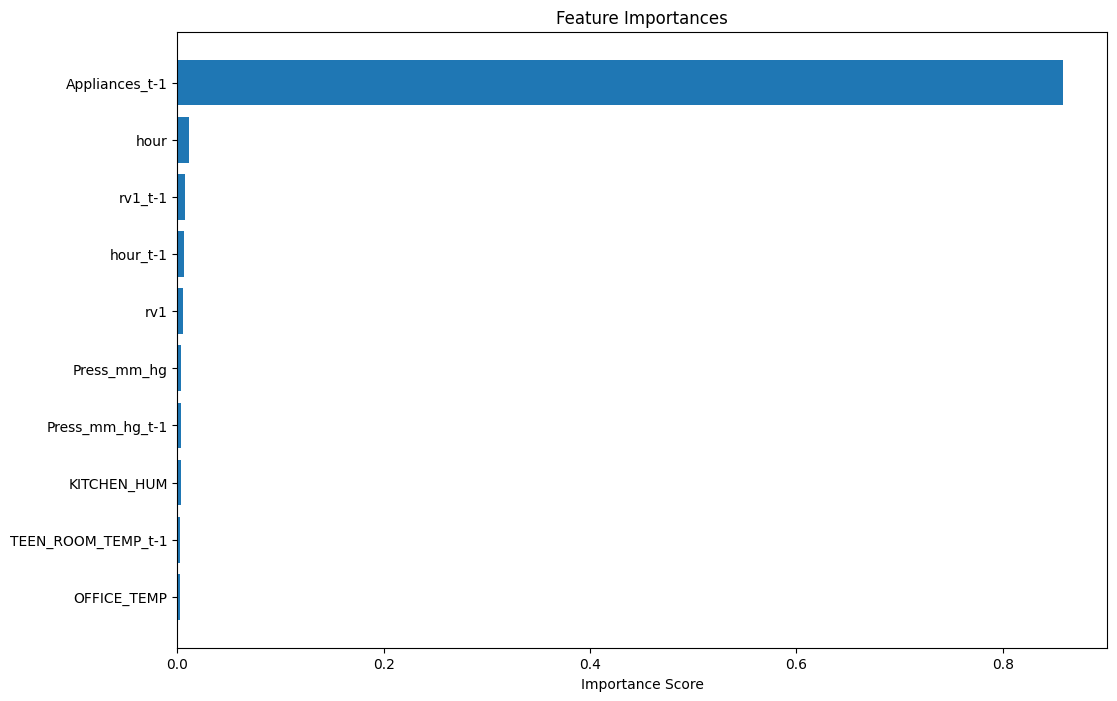

In [87]:
# Get Feature Importances
importances = rf.feature_importances_

# Sort Features by Importance
indices = np.argsort(importances)[::-1]

# Select Top Features
num_to_plot = 10
top_indices = indices[:num_to_plot]

# Get Sorted Feature Names and Importances
sorted_feature_names = [selected_features[i] for i in top_indices]
sorted_importances = importances[top_indices]

# Plotting
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.barh(range(num_to_plot), sorted_importances, align="center")
plt.yticks(range(num_to_plot), sorted_feature_names)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance Score")
plt.show()

Feed Forward Neural Network with Autoregressive Features

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Dense
import scikeras
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

def baseline_model():
   model = Sequential()
   model.add(Dense(64, input_shape=(59,), kernel_initializer='normal', activation='relu'))
   model.add(Dense(1, kernel_initializer='normal'))
   # Compile model
   model.compile(loss='mean_squared_error', optimizer='adam')
   return model

# evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)

y_pred_cv = cross_val_predict(estimator, X_train_transformed, y_train, cv=kfold)

# Calculate metrics on cross-validated predictions
mse_cv = mean_squared_error(y_train, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
mae_cv = mean_absolute_error(y_train, y_pred_cv)
mape_cv = mean_absolute_percentage_error(y_train, y_pred_cv)
r2_cv = r2_score(y_train, y_pred_cv)

# Output cross-validated results
print("Cross-Validated MSE: %.2f" % mse_cv)
print("Cross-Validated RMSE: %.2f" % rmse_cv)
print("Cross-Validated MAE: %.2f" % mae_cv)
print("Cross-Validated MAPE: %.2f" % mape_cv)
print("Cross-Validated R²: %.2f" % r2_cv)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Cross-Validated MSE: 550.15
Cross-Validated RMSE: 23.46
Cross-Validated MAE: 14.72
Cross-Validated MAPE: 0.21
Cross-Validated R²: 0.70


In [43]:
final_model = baseline_model()
final_model.fit(X_train_transformed, y_train, epochs=100, batch_size=5, verbose=0)

y_pred_test = final_model.predict(X_test_transformed)

# Calculate metrics on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Output test set results
print("Test MSE: %.2f" % mse_test)
print("Test RMSE: %.2f" % rmse_test)
print("Test MAE: %.2f" % mae_test)
print("Test MAPE: %.2f" % mape_test)
print("Test R²: %.2f" % r2_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MSE: 522.15
Test RMSE: 22.85
Test MAE: 14.44
Test MAPE: 0.21
Test R²: 0.71


**LSTM**

In [ ]:
X_train_trans.shape[1]

29

LSTM on the original data without autoregressive features

In [ ]:

# Define the LSTM model function
def lstm_model(input_shape, activation='tanh'):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation, return_sequences=True, input_shape=input_shape))  # First LSTM layer
    model.add(Dropout(0.1))
    model.add(LSTM(units=50))  # Second LSTM layer
    model.add(Dropout(0.1))
    model.add(Dense(1))  # Output layer
    model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model
    return model

# Reshape the training and testing data to be 3-dimensional [samples, timesteps, features]
X_train_trans_reshaped = X_train_trans.reshape((X_train_trans.shape[0], 1, X_train_trans.shape[1]))
X_test_trans_reshaped = X_test_trans.reshape((X_test_trans.shape[0], 1, X_test_trans.shape[1]))

# Initialize KerasRegressor
estimator_lstm = KerasRegressor(model=lambda: lstm_model(input_shape=(1, X_train_trans.shape[1])), epochs=100, batch_size=5, verbose=0)

# Initialize KFold for cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and obtain scores
scores = cross_validate(estimator_lstm, X_train_trans_reshaped, y_trained, cv=kfold,
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'),
                        return_train_score=False)

# Calculate metrics on cross-validated predictions
mse_lstm = -scores['test_neg_mean_squared_error'].mean()
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = -scores['test_neg_mean_absolute_error'].mean()
r2_lstm = scores['test_r2'].mean()
mape_lstm = -scores['test_neg_mean_absolute_percentage_error'].mean()

# Output cross-validated results
print("Cross-Validated MSE: %.2f" % mse_lstm)
print("Cross-Validated RMSE: %.2f" % rmse_lstm)
print("Cross-Validated MAE: %.2f" % mae_lstm)
print("Cross-Validated R^2: %.2f" % r2_lstm)
print("Cross-Validated MAPE: %.2f" % mape_lstm)

# Fit the final model on the entire training data
final_model_lstm = lstm_model(input_shape=(1, X_train_trans.shape[1]))
final_model_lstm.fit(X_train_trans_reshaped, y_trained, epochs=100, verbose=0)

# Start time
start_time = time.time()
# Predict on the test data
y_pred_test_lstm = final_model_lstm.predict(X_test_trans_reshaped)
# End time
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

# Calculate metrics on the test set
mse_test_lstm = mean_squared_error(y_tested, y_pred_test_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)
mae_test_lstm = mean_absolute_error(y_tested, y_pred_test_lstm)
mape_test_lstm = mean_absolute_percentage_error(y_tested, y_pred_test_lstm)
r2_test_lstm = r2_score(y_tested, y_pred_test_lstm)

# Output test set results
print("\nTest MSE: %.2f" % mse_test_lstm)
print("Test RMSE: %.2f" % rmse_test_lstm)
print("Test MAE: %.2f" % mae_test_lstm)
print("Test MAPE: %.2f" % mape_test_lstm)
print("Test R²: %.2f" % r2_test_lstm)
print("Test prediction_time: %.2f" %prediction_time)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Cross-Validated MSE: 703.99
Cross-Validated RMSE: 26.53
Cross-Validated MAE: 17.53
Cross-Validated R^2: 0.62
Cross-Validated MAPE: 17.53


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test MSE: 658.97
Test RMSE: 25.67
Test MAE: 17.46
Test MAPE: 0.25
Test R²: 0.64


In [ ]:
# Calculate metrics on cross-validated predictions
mse_lstm = -scores['test_neg_mean_squared_error'].mean()
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = -scores['test_neg_mean_absolute_error'].mean()
r2_lstm = scores['test_r2'].mean()
mape_lstm = -scores['test_neg_mean_absolute_percentage_error'].mean()

# Output cross-validated results
print("Cross-Validated MSE: %.2f" % mse_lstm)
print("Cross-Validated RMSE: %.2f" % rmse_lstm)
print("Cross-Validated MAE: %.2f" % mae_lstm)
print("Cross-Validated R^2: %.2f" % r2_lstm)
print("Cross-Validated MAPE: %.2f" % mape_lstm)

Cross-Validated MSE: 703.99
Cross-Validated RMSE: 26.53
Cross-Validated MAE: 17.53
Cross-Validated R^2: 0.62
Cross-Validated MAPE: 0.25


In [ ]:
# Output test set results
print("\nTest MSE: %.2f" % mse_test_lstm)
print("Test RMSE: %.2f" % rmse_test_lstm)
print("Test MAE: %.2f" % mae_test_lstm)
print("Test MAPE: %.2f" % mape_test_lstm)
print("Test R²: %.2f" % r2_test_lstm)
print("Test prediction_time: %.2f" %prediction_time)


Test MSE: 658.97
Test RMSE: 25.67
Test MAE: 17.46
Test MAPE: 0.25
Test R²: 0.64
Test prediction_time: 0.38


GRU on the original data without autoregressive features

In [ ]:

# Define the GRU model
def GRU_model(input_shape, activation='relu'):
    model = Sequential()
    model.add(GRU(units=50, activation=activation, return_sequences=True, input_shape=input_shape))  # First GRU layer
    model.add(Dropout(0.1))
    model.add(GRU(units=50))  # Second GRU layer
    model.add(Dropout(0.1))
    model.add(Dense(1))  # Output layer
    model.compile(loss='mean_squared_error', optimizer='adam')  # Compile the model
    return model

# Reshape the training and testing data to be 3-dimensional [samples, timesteps, features]
X_train_trans_reshaped = X_train_trans.reshape((X_train_trans.shape[0], 1, X_train_trans.shape[1]))
X_test_trans_reshaped = X_test_trans.reshape((X_test_trans.shape[0], 1, X_test_trans.shape[1]))

# Initialize KerasRegressor
estimator_GRU = KerasRegressor(model=GRU_model, input_shape=(1, X_train_trans.shape[1]), epochs=100, batch_size =5, verbose=0)

# Initialize KFold for cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)


# Perform cross-validation and obtain scores
scores_GRU = cross_validate(estimator_GRU, X_train_trans_reshaped, y_trained, cv=kfold,
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'),
                        return_train_score=False)


# Fit the final model on the entire training data
final_model_GRU = GRU_model(input_shape=(1, X_train_trans.shape[1]))
final_model_GRU.fit(X_train_trans_reshaped, y_trained, epochs=100,batch_size =5, verbose=0)



In [ ]:
# Calculate metrics on cross-validated predictions
mse_GRU = -scores['test_neg_mean_squared_error'].mean()
rmse_GRU = np.sqrt(mse_GRU)
mae_GRU = -scores['test_neg_mean_absolute_error'].mean()
r2_GRU = scores['test_r2'].mean()
mape_GRU = -scores['test_neg_mean_absolute_percentage_error'].mean()

# Output cross-validated results
print("Cross-Validated RMSE: %.2f" % rmse_GRU)
print("Cross-Validated MAE: %.2f" % mae_GRU)
print("Cross-Validated MAPE: %.2f" % mape_GRU)
print("Cross-Validated R²: %.2f" % r2_GRU)


Cross-Validated RMSE: 26.53
Cross-Validated MAE: 17.53
Cross-Validated MAPE: 0.25
Cross-Validated R²: 0.62


In [ ]:
# Start time
start_time = time.time()
# Predict on the test data
y_pred_test_GRU = final_model_GRU.predict(X_test_trans_reshaped)

# End time
end_time = time.time()

# Calculate the prediction time
prediction_time = end_time - start_time

# Calculate metrics on the test set
mse_test_gru = mean_squared_error(y_tested, y_pred_test_lstm)
rmse_test_gru = np.sqrt(mse_test_gru)
mae_test_gru = mean_absolute_error(y_tested, y_pred_test_GRU)
mape_test_gru = mean_absolute_percentage_error(y_tested, y_pred_test_GRU)
r2_test_gru = r2_score(y_tested, y_pred_test_GRU)

# Output test set results
print("Test MSE: %.2f" % mse_test_gru)
print("Test RMSE: %.2f" % rmse_test_gru)
print("Test MAE: %.2f" % mae_test_gru)
print("Test MAPE: %.2f" % mape_test_gru)
print("Test R²: %.2f" % r2_test_gru)
print("Prediction time: %.2f seconds" % prediction_time)

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE: 658.97
Test RMSE: 25.67
Test MAE: 17.12
Test MAPE: 0.24
Test R²: 0.65
Prediction time: 0.38 seconds


Actual vs Predicted for one week data

In [64]:
df_train_clean['date'] = df_train_clean['date'].dt.date
df_test_clean['date'] = df_test_clean['date'].dt.date

In [65]:
start_date = pd.to_datetime('2016-05-02').date()
end_date = pd.to_datetime('2016-05-08').date()

# Filter df_train_clean to include only rows with dates in df_test_clean
filtered_df_train_clean = df_train_clean[(df_train_clean['date'] >= start_date) & (df_train_clean['date'] <= end_date)]

# Display the filtered DataFrame
print(filtered_df_train_clean.count())
# Filter df_train_clean to include only rows with dates in df_test_clean
filtered_df_test_clean = df_test_clean[(df_test_clean['date'] >= start_date) & (df_test_clean['date'] <= end_date)]

# Display the filtered DataFrame
print(filtered_df_test_clean.count())

Appliances_t-1      744
lights_t-1          744
lights              744
KITCHEN_TEMP_t-1    744
KITCHEN_TEMP        744
                   ... 
rv2_t-1             744
rv2                 744
date_t-1            744
date                744
Appliances          744
Length: 70, dtype: int64
Appliances_t-1      264
lights_t-1          264
lights              264
KITCHEN_TEMP_t-1    264
KITCHEN_TEMP        264
                   ... 
rv2_t-1             264
rv2                 264
date_t-1            264
date                264
Appliances          264
Length: 70, dtype: int64


In [66]:
X_train_plt = filtered_df_train_clean[selected_features]
y_train_plt = filtered_df_train_clean['Appliances']
X_train_plt.shape
y_train_plt.shape

X_test_plt = filtered_df_test_clean[selected_features]
y_test_plt = filtered_df_test_clean['Appliances']
X_test_plt.shape
y_test_plt.shape

(264,)

In [67]:
# normalise the training data
from sklearn.preprocessing import StandardScaler
ss_scaler = StandardScaler()
ss_scaler.fit(X_train_plt)
X_train_plt = ss_scaler.transform(X_train_plt)
X_test_plt = ss_scaler.transform(X_test_plt)

In [69]:
# LM
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
lm_model1 = LinearRegression()
param_rs_lm = {'fit_intercept': [True, False],
              'copy_X': [True, False],
               'positive':[True, False]
             }
rs_lm1 = RandomizedSearchCV(lm_model1, param_distributions=param_rs_lm, n_iter=3,cv=kfold,scoring ='r2',random_state = 42)
rs_lm1.fit(X_train_plt, y_train_plt)
lm_bestModel1 = rs_lm1.best_estimator_
print(lm_bestModel1)
print(rs_lm1.best_score_)
print(rs_lm1.best_params_)

LinearRegression(positive=True)
0.600105400121761
{'positive': True, 'fit_intercept': True, 'copy_X': True}


In [71]:
lm_model1 =LinearRegression(positive = False, fit_intercept= True, copy_X= True)
lm_model1.fit(X_train_plt, y_train_plt)
y_pred_lm_plt = lm_model1.predict(X_test_plt)

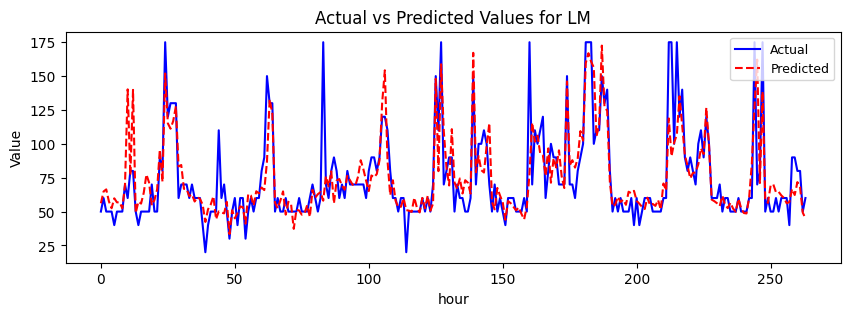

In [72]:
# Plotting

hours = range(len(y_test_plt))

plt.figure(figsize=(10, 3))
plt.plot(hours, y_test_plt, label='Actual', color='blue')
plt.plot(hours, y_pred_lm_plt, label='Predicted', color='red', linestyle='--')

plt.title('Actual vs Predicted Values for LM')
plt.xlabel('hour')
plt.ylabel('Value')
plt.legend(fontsize=9, loc='upper right')
plt.show()

In [73]:
# GBM
from sklearn.ensemble import GradientBoostingRegressor
gbm_model1 = GradientBoostingRegressor()
param_rs_gbm = {'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
              'criterion' : ['friedman_mse', 'squared_error'],
              'n_estimators': [100],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': [None, 'sqrt', 'log2'],
            'subsample': [0.7, 0.8, 0.9, 1.0]
               }
rs_gbm1 = RandomizedSearchCV(gbm_model1, param_distributions=param_rs_gbm, n_iter=3,cv=kfold,scoring='r2',random_state=42)
rs_gbm1.fit(X_train_plt, y_train_plt)
gbm_bestModel1 = rs_gbm1.best_estimator_
print(gbm_bestModel1)
print(rs_gbm1.best_score_)
print(rs_gbm1.best_params_)


GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features='log2',
                          min_samples_leaf=5, subsample=0.9)
0.599615717992114
{'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 4, 'loss': 'squared_error', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [74]:
gbm_model1 = GradientBoostingRegressor(subsample = 0.9, n_estimators= 100, min_samples_split= 2, min_samples_leaf= 5, max_features= 'log2',
                                       max_depth= 4, loss= 'squared_error', learning_rate= 0.2, criterion= 'friedman_mse')
gbm_model1.fit(X_train_plt, y_train_plt)
y_pred_gbm_plt = gbm_model1.predict(X_test_plt)


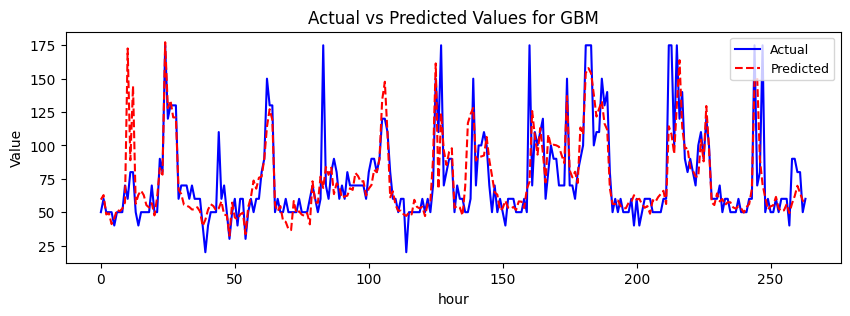

In [77]:
# Plotting

hours = range(len(y_test_plt))

plt.figure(figsize=(10, 3))
plt.plot(hours, y_test_plt, label='Actual', color='blue')
plt.plot(hours, y_pred_gbm_plt, label='Predicted', color='red', linestyle='--')

plt.title('Actual vs Predicted Values for GBM')
plt.xlabel('hour')
plt.ylabel('Value')
plt.legend(fontsize=9, loc='upper right')
plt.show()

In [75]:
#SVM
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
SVR_model1 = SVR()
param_rs_svr = { 'kernel': ['rbf', 'poly','sigmoid'],
                  'degree' : [3],
                   'gamma' : ['scale'],
                   'C': [0.1, 1, 10],
                   'epsilon': [0.1, 0.2, 0.3]
               }
rs_svr1 = RandomizedSearchCV(SVR_model1, param_distributions=param_rs_svr, n_iter=3,cv=kfold,scoring='r2',random_state=42)
rs_svr1.fit(X_train_plt, y_train_plt)
svr_bestModel1 = rs_svr1.best_estimator_
print(svr_bestModel1)
print(rs_svr1.best_score_)
print(rs_svr1.best_params_)


SVR(C=1)
0.19469226682630775
{'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.1, 'degree': 3, 'C': 1}


In [76]:
SVR_model1 = SVR(kernel = 'rbf', gamma = 'scale', epsilon= 0.1, degree = 3,C=1)
SVR_model1.fit(X_train_plt, y_train_plt)
y_pred_svr_plt = SVR_model1.predict(X_test_plt)

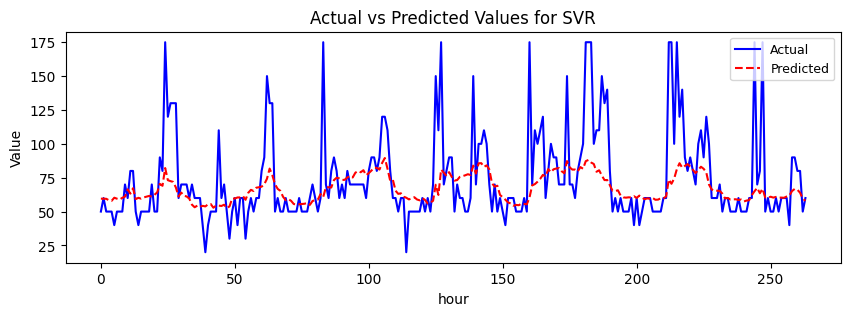

In [78]:
# Plotting

hours = range(len(y_test_plt))

plt.figure(figsize=(10, 3))
plt.plot(hours, y_test_plt, label='Actual', color='blue')
plt.plot(hours, y_pred_svr_plt, label='Predicted', color='red', linestyle='--')

plt.title('Actual vs Predicted Values for SVR')
plt.xlabel('hour')
plt.ylabel('Value')
plt.legend(fontsize=9, loc='upper right')
plt.show()

In [79]:
#RF
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf1 = RandomForestRegressor()
param_rs_rf = {'n_estimators' :  [50,100, 200],
              'criterion' : ['squared_error', 'friedman_mse'],
               'max_depth' : [None, 10, 20],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2, 5],
                'bootstrap': [True] }
rs_rf1 = RandomizedSearchCV(rf1, param_distributions=param_rs_rf, n_iter=3,cv=kfold, scoring ='r2',random_state=42)
rs_rf1.fit(X_train_plt, y_train_plt)
rf_bestModel1 = rs_rf1.best_estimator_
print(rf_bestModel1)
print(rs_rf1.best_score_)
print(rs_rf1.best_params_)


RandomForestRegressor(min_samples_leaf=2, min_samples_split=5)
0.5839959934643918
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': True}


In [80]:
rf1 = RandomForestRegressor(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 2, max_depth = None, criterion = 'squared_error', bootstrap = True)
rf1.fit(X_train_plt, y_train_plt)
y_pred_rf_plt = rf1.predict(X_test_plt)

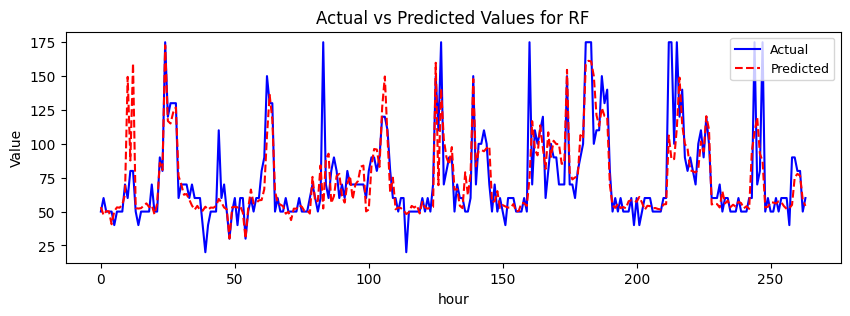

In [81]:
# Plotting

hours = range(len(y_test_plt))

plt.figure(figsize=(10, 3))
plt.plot(hours, y_test_plt, label='Actual', color='blue')
plt.plot(hours, y_pred_rf_plt, label='Predicted', color='red', linestyle='--')

plt.title('Actual vs Predicted Values for RF')
plt.xlabel('hour')
plt.ylabel('Value')
plt.legend(fontsize=9, loc='upper right')
plt.show()

PCA on Autoregressive feature data

In [ ]:
column_names_list = df_train_clean[selected_features].columns.tolist()
column_names_list

['Appliances_t-1',
 'lights_t-1',
 'lights',
 'KITCHEN_TEMP_t-1',
 'KITCHEN_TEMP',
 'LIVING_TEMP_t-1',
 'LIVING_TEMP',
 'BEDROOM_TEMP_t-1',
 'BEDROOM_TEMP',
 'OFFICE_TEMP_t-1',
 'OFFICE_TEMP',
 'BATHROOM_TEMP_t-1',
 'BATHROOM_TEMP',
 'OUTSIDE_TEMP_build_t-1',
 'OUTSIDE_TEMP_build',
 'IRONING_ROOM_TEMP_t-1',
 'IRONING_ROOM_TEMP',
 'TEEN_ROOM_TEMP_t-1',
 'TEEN_ROOM_TEMP',
 'PARENTS_ROOM_TEMP_t-1',
 'PARENTS_ROOM_TEMP',
 'OUTSIDE_TEMP_wstn_t-1',
 'OUTSIDE_TEMP_wstn',
 'KITCHEN_HUM_t-1',
 'KITCHEN_HUM',
 'LIVING_HUM_t-1',
 'LIVING_HUM',
 'BEDROOM_HUM_t-1',
 'BEDROOM_HUM',
 'OFFICE_HUM_t-1',
 'OFFICE_HUM',
 'BATHROOM_HUM_t-1',
 'BATHROOM_HUM',
 'OUTSIDE_HUM_build_t-1',
 'OUTSIDE_HUM_build',
 'IRONING_ROOM_HUM_t-1',
 'IRONING_ROOM_HUM',
 'TEEN_ROOM_HUM_t-1',
 'TEEN_ROOM_HUM',
 'PARENTS_ROOM_HUM_t-1',
 'PARENTS_ROOM_HUM',
 'OUTSIDE_HUM_wstn_t-1',
 'OUTSIDE_HUM_wstn',
 'Tdewpoint_t-1',
 'Tdewpoint',
 'Press_mm_hg_t-1',
 'Press_mm_hg',
 'Windspeed_t-1',
 'Windspeed',
 'rv1_t-1',
 'rv1',
 'month

Explained Variance Ratio:
Principal Component 1: 0.3392 (33.92%)
Principal Component 2: 0.2450 (24.50%)
Principal Component 3: 0.0722 (7.22%)
Principal Component 4: 0.0460 (4.60%)
Principal Component 5: 0.0344 (3.44%)
Principal Component 6: 0.0319 (3.19%)
Principal Component 7: 0.0274 (2.74%)
Principal Component 8: 0.0218 (2.18%)
Principal Component 9: 0.0195 (1.95%)
Principal Component 10: 0.0185 (1.85%)
Principal Component 11: 0.0175 (1.75%)
Principal Component 12: 0.0169 (1.69%)
Principal Component 13: 0.0169 (1.69%)
Principal Component 14: 0.0144 (1.44%)
Principal Component 15: 0.0141 (1.41%)
Principal Component 16: 0.0112 (1.12%)
Principal Component 17: 0.0065 (0.65%)
Principal Component 18: 0.0051 (0.51%)
Principal Component 19: 0.0050 (0.50%)
Principal Component 20: 0.0048 (0.48%)
Principal Component 21: 0.0042 (0.42%)
Principal Component 22: 0.0039 (0.39%)
Principal Component 23: 0.0038 (0.38%)
Principal Component 24: 0.0036 (0.36%)
Principal Component 25: 0.0032 (0.32%)
Princi

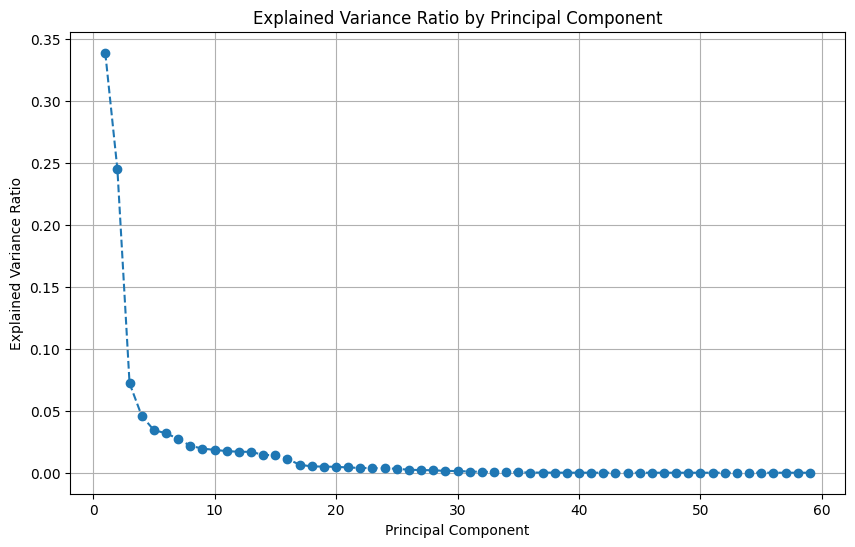

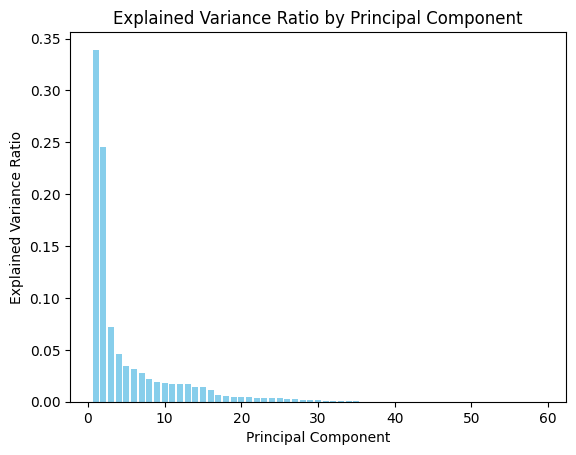

In [ ]:
# PCA transformation on train data and find the explained variance
pca = PCA()
pca.fit(X_train_transformed)
X_train_pca = pca.transform(X_train_transformed)
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio for each principal component
print("Explained Variance Ratio:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal Component {i + 1}: {ratio:.4f} ({ratio * 100:.2f}%)")

# Plotting the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.grid(True)
plt.show()

# Plot the explained variance

# Generate x values (component indices)
x_values = np.arange(1, len(explained_variance_ratio) + 1)

# Plot the explained variance ratio as a bar chart
plt.bar(x_values, explained_variance_ratio, color='skyblue')

# Labeling the axes
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

# Adding a title
plt.title('Explained Variance Ratio by Principal Component')

# Show the plot
plt.show()


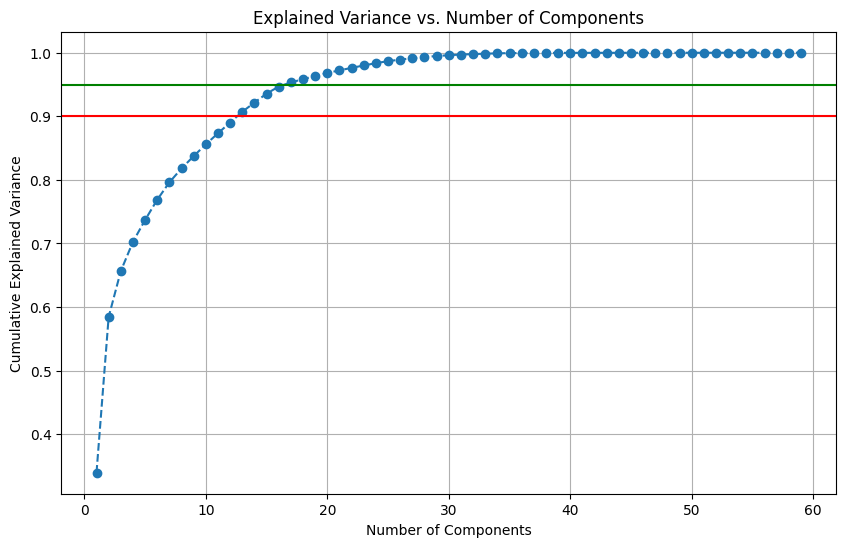

Number of components to retain 95% variance: 17

PCA Components (Top 17):

Component 1:
PARENTS_ROOM_TEMP, PARENTS_ROOM_TEMP_t-1, BEDROOM_TEMP, BEDROOM_TEMP_t-1, IRONING_ROOM_TEMP, OFFICE_TEMP, IRONING_ROOM_TEMP_t-1, OFFICE_TEMP_t-1, KITCHEN_TEMP, BATHROOM_TEMP, BATHROOM_TEMP_t-1, KITCHEN_TEMP_t-1, month_t-1, month, TEEN_ROOM_TEMP, TEEN_ROOM_TEMP_t-1, LIVING_TEMP_t-1, LIVING_TEMP, OUTSIDE_TEMP_wstn_t-1, OUTSIDE_TEMP_wstn, OUTSIDE_TEMP_build_t-1, OUTSIDE_TEMP_build, OUTSIDE_HUM_build, OUTSIDE_HUM_build_t-1, Tdewpoint_t-1, Tdewpoint, OUTSIDE_HUM_wstn, OUTSIDE_HUM_wstn_t-1, KITCHEN_HUM_t-1, Appliances_t-1, KITCHEN_HUM, hour, hour_t-1, Press_mm_hg, BATHROOM_HUM, BATHROOM_HUM_t-1, BEDROOM_HUM, BEDROOM_HUM_t-1, lights, lights_t-1, Press_mm_hg_t-1, TEEN_ROOM_HUM, TEEN_ROOM_HUM_t-1, Windspeed, Windspeed_t-1, IRONING_ROOM_HUM_t-1, IRONING_ROOM_HUM, OFFICE_HUM_t-1, OFFICE_HUM, LIVING_HUM, LIVING_HUM_t-1, dayofweek_t-1, dayofweek, PARENTS_ROOM_HUM_t-1, rv1_t-1, rv1, PARENTS_ROOM_HUM, minutes_t-1,

In [ ]:
#Find the components for 95% variance and plot the graph
cumulativesum = np.cumsum(pca.explained_variance_ratio_)
pca_components = pd.DataFrame(pca.components_, columns=column_names_list)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulativesum) + 1), cumulativesum, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.grid(True)
plt.show()

# Determine the number of components needed to retain 95% variance

n_components = np.argmax(cumulativesum >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

# Display the components
print(f"\nPCA Components (Top {n_components}):\n")
for i in range(n_components):
    sorted_indices = np.argsort(np.abs(pca.components_[i]))[::-1]
    component_str = ', '.join([f"{column_names_list[j]}" for j in sorted_indices])
    print(f"Component {i + 1}:\n{component_str}\n")


PCA Components (Top 17):

Component 1 Top Features:
PARENTS_ROOM_TEMP: 0.2107
PARENTS_ROOM_TEMP_t-1: 0.2106
BEDROOM_TEMP: 0.2059
BEDROOM_TEMP_t-1: 0.2055
IRONING_ROOM_TEMP: 0.2053
OFFICE_TEMP: 0.2049
IRONING_ROOM_TEMP_t-1: 0.2049
OFFICE_TEMP_t-1: 0.2047
KITCHEN_TEMP: 0.2042
BATHROOM_TEMP: 0.2039

Component 2 Top Features:
OFFICE_HUM: 0.2521
OFFICE_HUM_t-1: 0.2518
IRONING_ROOM_HUM_t-1: 0.2466
IRONING_ROOM_HUM: 0.2466
BEDROOM_HUM: 0.2422
BEDROOM_HUM_t-1: 0.2414
TEEN_ROOM_HUM_t-1: 0.2412
TEEN_ROOM_HUM: 0.2411
PARENTS_ROOM_HUM: 0.2386
PARENTS_ROOM_HUM_t-1: 0.2380

Component 3 Top Features:
hour: 0.3010
hour_t-1: 0.2960
OUTSIDE_HUM_wstn_t-1: -0.2940
OUTSIDE_HUM_wstn: -0.2935
Windspeed_t-1: 0.2904
Windspeed: 0.2901
Appliances_t-1: 0.1896
OUTSIDE_TEMP_build_t-1: 0.1830
OUTSIDE_TEMP_build: 0.1813
OUTSIDE_TEMP_wstn: 0.1813

Component 4 Top Features:
lights_t-1: 0.3870
lights: 0.3826
hour_t-1: 0.2973
hour: 0.2927
Appliances_t-1: 0.2103
BATHROOM_HUM: 0.2099
BATHROOM_HUM_t-1: 0.2070
dayofweek: -0

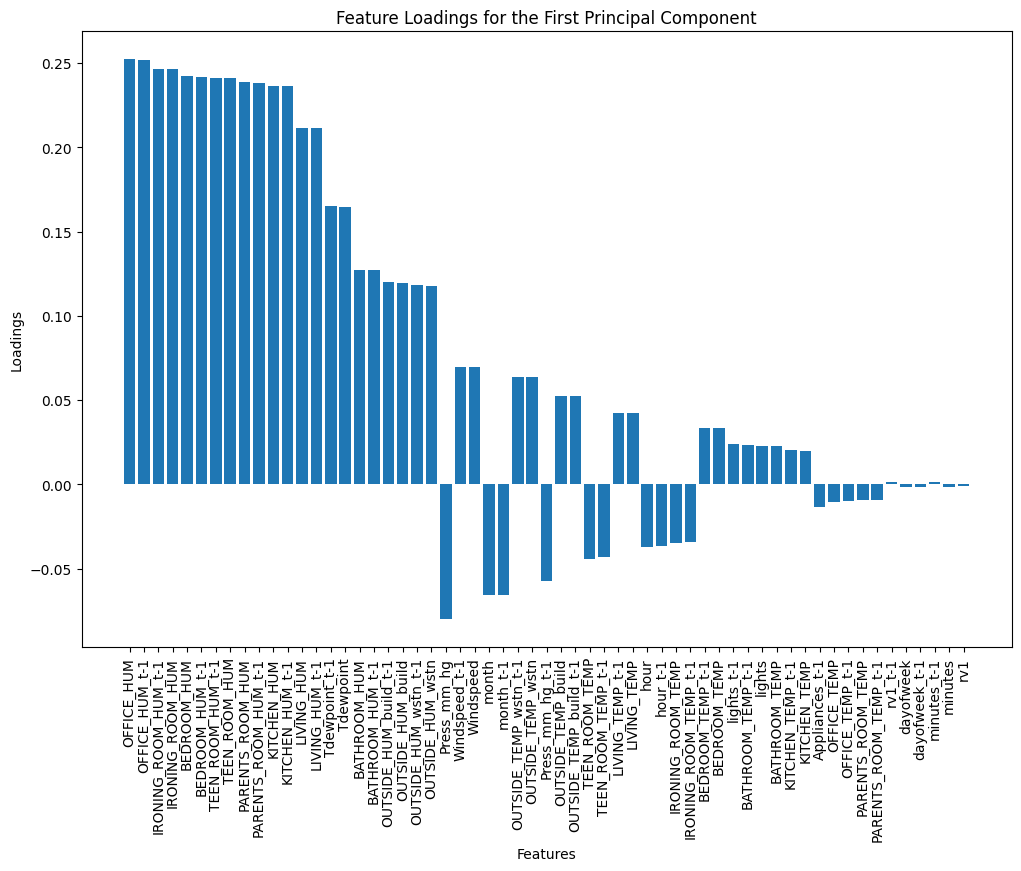

In [ ]:
# find the features in each principal components
print(f"\nPCA Components (Top {n_components}):\n")
for i in range(n_components):
    sorted_indices = np.argsort(np.abs(pca.components_[i]))[::-1]
    top_features = [column_names_list[j] for j in sorted_indices[:10]]
    top_loadings = pca.components_[i, sorted_indices[:10]]
    print(f"Component {i + 1} Top Features:")
    for feature, loading in zip(top_features, top_loadings):
        print(f"{feature}: {loading:.4f}")
    print()

# Plot the loadings for the first principal component as an example
plt.figure(figsize=(12, 8))
component_index = 1  # First principal component, change this index to plot other components
sorted_indices = np.argsort(np.abs(pca.components_[component_index]))[::-1]
top_features = [column_names_list[i] for i in sorted_indices]
top_loadings = pca.components_[component_index, sorted_indices]

plt.bar(top_features, top_loadings, align='center')
plt.ylabel('Loadings')
plt.xlabel('Features')
plt.title('Feature Loadings for the First Principal Component')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#PCA on all the models on all the components

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'Support Vector Regression': SVR(),
    'Gradient Boosting Regression':GradientBoostingRegressor()
}
results =[]
for model_name, model in models.items():
    pca = PCA()
    pca.fit(X_train_transformed)
    X_train_pca = pca.transform(X_train_transformed)
    X_test_PCA = pca.transform(X_test_transformed)
    model.fit(X_train_pca, y_train)


    score_pca = cross_validate(model, X_train_pca, y_train, cv=kfold, scoring=metrics_calculate)

    # Calculate evaluation metrics for the training predictions
    train_pca_rmse = np.mean(np.sqrt(-score_pca['test_neg_mean_squared_error']))  # RMSE
    train_pca_r2 = np.mean(score_pca['test_r2'])  # R2 Score
    train_pca_mae = np.mean(-score_pca['test_neg_mean_absolute_error'])  # MAE
    train_pca_mape = np.mean(-score_pca['test_neg_mean_absolute_percentage_error'])  # MAPE

    # Calculate the total time taken to train and test
    start_time = time.perf_counter()
    # Evaluate the best model on the test set
    y_pred_pca = model.predict(X_test_PCA)
    time_elapsed = time.perf_counter()-start_time

    # Calculate evaluation metrics for the test predictions
    test_pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pca))
    test_pca_r2 = r2_score(y_test, y_pred_pca)
    test_pca_mae = mean_absolute_error(y_test, y_pred_pca)
    test_pca_mape = mean_absolute_percentage_error(y_test, y_pred_pca)

    results.append({
            'Model': model_name,
            'Train R2': train_pca_r2,
            'Test R2': test_pca_r2,
            'Train RMSE': train_pca_rmse,
            'Test RMSE': test_pca_rmse,
            'Train MAPE': train_pca_mape,
            'Test MAPE': test_pca_mape,
            'Train MAE': train_pca_mae,
            'Test MAE': test_pca_mae,
            'Time Elapsed': time_elapsed
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results in a tabular form
print(results_df)

                          Model  Train R2   Test R2  Train RMSE  Test RMSE  \
0             Linear Regression -2.160721  0.716531   43.873181  22.786335   
1                 Random Forest  0.700551  0.694813   23.509110  23.643112   
2     Support Vector Regression  0.646909  0.650486   25.540361  25.301924   
3  Gradient Boosting Regression  0.689745  0.680553   23.931267  24.189154   

   Train MAPE  Test MAPE  Train MAE   Test MAE  Time Elapsed  
0    0.216181   0.204154  15.128786  14.374616      0.000642  
1    0.219150   0.216676  15.203772  15.046129      0.111496  
2    0.215322   0.210542  16.640190  16.225150      7.521543  
3    0.229258   0.228529  15.634775  15.593898      0.010535  


In [ ]:
#PCA on all the models on the first 17 components

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0),
    'Support Vector Regression': SVR(),
    'Gradient Boosting Regression':GradientBoostingRegressor()
}
results =[]
for model_name, model in models.items():
    number = 17
    pca = PCA(n_components = number)
    pca.fit(X_train_transformed)
    X_train_pca = pca.transform(X_train_transformed)
    X_test_PCA = pca.transform(X_test_transformed)
    model.fit(X_train_pca, y_train)

    score_pca = cross_validate(model, X_train_pca, y_train, cv=kfold, scoring=metrics_calculate)

    # Calculate evaluation metrics for the training predictions
    train_pca_rmse = np.mean(np.sqrt(-score_pca['test_neg_mean_squared_error']))  # RMSE
    train_pca_r2 = np.mean(score_pca['test_r2'])  # R2 Score
    train_pca_mae = np.mean(-score_pca['test_neg_mean_absolute_error'])  # MAE
    train_pca_mape = np.mean(-score_pca['test_neg_mean_absolute_percentage_error'])  # MAPE

    # Calculate the total time taken to train and test
    start_time = time.perf_counter()

    # Evaluate the best model on the test set
    y_pred_pca = model.predict(X_test_PCA)

    time_elapsed = time.perf_counter()-start_time

    # Calculate evaluation metrics for the test predictions
    test_pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pca))
    test_pca_r2 = r2_score(y_test, y_pred_pca)
    test_pca_mae = mean_absolute_error(y_test, y_pred_pca)
    test_pca_mape = mean_absolute_percentage_error(y_test, y_pred_pca)

    results.append({
            'Model': model_name,
            'Train R2': train_pca_r2,
            'Test R2': test_pca_r2,
            'Train RMSE': train_pca_rmse,
            'Test RMSE': test_pca_rmse,
            'Train MAPE': train_pca_mape,
            'Test MAPE': test_pca_mape,
            'Train MAE': train_pca_mae,
            'Test MAE': test_pca_mae,
            'Time Elapsed': time_elapsed
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results in a tabular form
print(results_df)

                          Model  Train R2   Test R2  Train RMSE  Test RMSE  \
0             Linear Regression  0.711356  0.704244   23.082835  23.274904   
1                 Random Forest  0.699657  0.692643   23.547834  23.727023   
2     Support Vector Regression  0.648649  0.649176   25.476440  25.349317   
3  Gradient Boosting Regression  0.686940  0.675801   24.041854  24.368432   

   Train MAPE  Test MAPE  Train MAE   Test MAE  Time Elapsed  
0    0.210839   0.209972  14.829483  14.770422      0.003758  
1    0.218188   0.215690  15.244135  15.097700      0.107799  
2    0.216762   0.212366  16.639841  16.254060      3.983980  
3    0.228605   0.227520  15.661954  15.629052      0.006277  


In [ ]:
#PCA on all the models on first 17 components with the hyperparameters obtained from randomsearch

# Define models to evaluate
models = {
    'Linear Regression': LinearRegression(positive = True, fit_intercept = True, copy_X = True),
    'Random Forest': RandomForestRegressor(n_estimators = 200, min_samples_split = 5, max_depth = 10, criterion = 'friedman_mse'),
    'Support Vector Regression': SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.1, degree = 3, C= 1),
    'Gradient Boosting Regression':GradientBoostingRegressor(learning_rate=0.2, max_depth=4, max_features='log2',min_samples_leaf=5, subsample=0.9)

}
results =[]
for model_name, model in models.items():
    number = 17
    pca = PCA(n_components = number)
    pca.fit(X_train_transformed)
    X_train_pca = pca.transform(X_train_transformed)
    X_test_PCA = pca.transform(X_test_transformed)
    model.fit(X_train_pca, y_train)

    score_pca = cross_validate(model, X_train_pca, y_train, cv=kfold, scoring=metrics_calculate)

    # Calculate evaluation metrics for the training predictions
    train_pca_rmse = np.mean(np.sqrt(-score_pca['test_neg_mean_squared_error']))  # RMSE
    train_pca_r2 = np.mean(score_pca['test_r2'])  # R2 Score
    train_pca_mae = np.mean(-score_pca['test_neg_mean_absolute_error'])  # MAE
    train_pca_mape = np.mean(-score_pca['test_neg_mean_absolute_percentage_error'])  # MAPE

    # Calculate the total time taken to train and test
    start_time = time.perf_counter()

    # Evaluate the best model on the test set
    y_pred_pca = model.predict(X_test_PCA)

    time_elapsed = time.perf_counter()-start_time

    # Calculate evaluation metrics for the test predictions
    test_pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pca))
    test_pca_r2 = r2_score(y_test, y_pred_pca)
    test_pca_mae = mean_absolute_error(y_test, y_pred_pca)
    test_pca_mape = mean_absolute_percentage_error(y_test, y_pred_pca)

    results.append({
            'Model': model_name,
            'Train R2': train_pca_r2,
            'Test R2': test_pca_r2,
            'Train RMSE': train_pca_rmse,
            'Test RMSE': test_pca_rmse,
            'Train MAPE': train_pca_mape,
            'Test MAPE': test_pca_mape,
            'Train MAE': train_pca_mae,
            'Test MAE': test_pca_mae,
            'Time Elapsed': time_elapsed
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results in a tabular form
print(results_df)

                          Model  Train R2   Test R2  Train RMSE  Test RMSE  \
0             Linear Regression  0.662635  0.650858   24.957358  25.288472   
1                 Random Forest  0.685851  0.675942   24.077458  24.363105   
2     Support Vector Regression  0.648649  0.649176   25.476440  25.349317   
3  Gradient Boosting Regression  0.697483  0.687980   23.637590  23.906307   

   Train MAPE  Test MAPE  Train MAE   Test MAE  Time Elapsed  
0    0.249418   0.253205  17.154928  17.288383      0.000310  
1    0.230423   0.228035  15.753594  15.667325      0.087392  
2    0.216762   0.212366  16.639841  16.254060      3.991800  
3    0.220006   0.218570  15.325576  15.261642      0.007400  


**End of Code**